# PRISM: Spatial Correlation Among Grid Cells

The purpose of this notebook is to undertake a preliminary examination of spatial correlation among precipitation values across PRISM grid cells. This is done on a per month basis as the weather patterns are expected to change seasonally.

The products of this notebook are:

1. Monthly precipitation contour plots
2. Data posting plots for a selection of basic, descriptive statistics including L-moments.
    - The underlying DataFrames are exported to pickle format and saved to a spreadsheet
    - The geodataframes could be exported to shapefiles if desired
3. Correlogram, covariance, and variogram hexagram plots for each month. The offset distance, $\left| h \right|$ is the distance between grid centers.
    - The underlying DataFrames are exported to pickle format and saved to a spreadsheet

Prior to distribution fitting, a clustering analysis will be conducted on the monthly L-moments, L-CV, L-skewness, and L-kurtosis in an attempt to identify the regions preliminary identified as part of the data posting plots.

For distribution analysis in R, **WetDays_1981-2010.feather** should be used as the starting point.

In [1]:
# this tells Jupyter to embed matplotlib plots in the notebook
%matplotlib notebook

In [2]:
from IPython.display import display, HTML
import os
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
from copy import deepcopy
import statsmodels as sm
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import shapely as sp
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.tri as tri
import matplotlib.path as MPath
import geoplot as gplt
from math import sqrt, pow, ceil
import itertools

In [3]:
CRS_UTMWGS84 = {'init': 'epsg:32614'}

In [4]:
OUT_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Da' \
          r'ta\JNotes\Processed\PRISM'

Load the shapefile of the watershed for reference

In [5]:
WS_SHP = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\GI' \
         r'S\Shapefiles\UTM14N\Hydrology\Watersheds\Dolan_Creek_Watershed.shp'

In [6]:
DCWS = gpd.read_file( WS_SHP )
UTMCRS = DCWS.crs
UTMCRS

{'init': 'epsg:32614'}

Also load the shapefile of grid polygons for use in "data posting"-style analysis

In [7]:
IN_POLY = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\D' \
          r'ata\Weather\PRISM_Daily\AOI_PRISM_Poly.shp'

In [8]:
gpdPolys = gpd.read_file( IN_POLY )

Have a DataFrame saved as a pickle file of all of the wet days. Use this as the base for the calculations in this notebook

In [9]:
IN_PICKLE = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\D' \
            r'ata\JNotes\Processed\PRISM\WetDays_1981-2010.pickle'

In [10]:
WetDF = pd.read_pickle( IN_PICKLE )

In [11]:
display( HTML( WetDF.head().to_html() ) )

Now need to go through the existing wet days DataFrame and build a new DataFrame from arrays. Our arrays will be:

1. Grid_Id
2. Date
3. Precip_mm


In [12]:
TotPrecipDays = WetDF['Wet_Count'].sum()
TotPrecipDays

436716

In [13]:
# initialize our values
GridID = np.zeros( TotPrecipDays, dtype=np.int32 )
PrecipD = np.zeros( TotPrecipDays, dtype=np.float32 )
DateList = [ dt.datetime( 2019, 8, 5, 0, 0, 0) for x in range(TotPrecipDays) ]

In [14]:
NumDFRows = len( WetDF )
NumDFRows

226190

In [15]:
AllCols = list( WetDF.columns )
RootCols = deepcopy( AllCols[:6] )
DayCols = deepcopy( AllCols[6:] )

In [16]:
iCnt = 0
for iI in range( NumDFRows ):
    cRow = WetDF.loc[iI]
    cGridId = int( cRow.at["Grid_Id"] )
    cNumWet = int( cRow.at["Wet_Count"] )
    cYear = int( cRow.at["Year"] )
    cMonth = int( cRow.at["Month"] )
    cDay = int( cRow.at["Day"] )
    curDate = dt.datetime( cYear, cMonth, cDay, 0, 0, 0 )
    for jJ in range(cNumWet):
        cPDep = float( cRow.at[DayCols[jJ]] )
        GridID[iCnt] = cGridId
        PrecipD[iCnt] = cPDep
        DateList[iCnt] = curDate
        iCnt += 1
        curDate = curDate + dt.timedelta( days=1 )
    # end of inner for
# end of outer for

In [17]:
DataDict = { "DateTime" : DateList,
             "Grid_Id" : GridID,
             "Precip_mm" : PrecipD, }
GPrecipDF = pd.DataFrame( data=DataDict )

In [18]:
display( HTML( GPrecipDF.head().to_html() ) )

In [19]:
MaxDailyPrecip = GPrecipDF['Precip_mm'].max()
MaxDailyPrecip

361.53

Now we want to pivot the DataFrame to have an index of grid cells and columns that are date time intervals.

In [20]:
SpatTableDF = GPrecipDF.pivot( index='Grid_Id', columns='DateTime', values='Precip_mm' )

In [21]:
SpatTableDF.fillna( value=0.0, inplace=True )

In [22]:
display( HTML( SpatTableDF.describe().to_html() ) )

Also need the coordinates of the grid cells to provide for the spatial component of the analysis

In [23]:
IN_GRID_XLSX = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\D' \
               r'ata\JNotes\Processed\PRISM\Precip_Agg_1981-2010.xlsx'
GSHEET = r'Grid_Metadata'
GRD_HDRS = [ 'Id', #0
             'Grid_Index', #1
             'Longitude', #2
             'Lattitude', #3
             'utm_x', #5
             'utm_y', #6
]

In [24]:
GridDF = pd.read_excel( IN_GRID_XLSX, sheet_name=GSHEET, header=0, names=GRD_HDRS, index_col=0 )

In [25]:
display( HTML( GridDF.head().to_html() ) )

In [26]:
NumGrid = len( GridDF )
NumGrid

210

In [27]:
GPntList = [ Point(x,y) for x,y in zip( GridDF['utm_x'].tolist(), GridDF['utm_y'].tolist() ) ]

In [28]:
GPt_Dict = dict( zip( GridDF['Grid_Index'].tolist(), GPntList ) )

Now have a dictionary of grid points by Grid_Id

Combine the point locations with precipitation depths into a GeoDataFrame

In [29]:
IndexGridIDs = SpatTableDF.index.tolist()
AddPtList = list()
for tGID in IndexGridIDs:
    AddPtList.append( GPt_Dict[tGID] )
# end of for

In [30]:
cpyDF = SpatTableDF.copy()
gpdPrecip = gpd.GeoDataFrame( cpyDF, geometry=AddPtList )

In [31]:
gpdPrecip.crs = UTMCRS

In [32]:
display( HTML( gpdPrecip.head().to_html() ))

## Spatial Correlation Analysis

We have a number of goals here

In [33]:
AllDateCols = list( SpatTableDF.columns )

In [34]:
TotNumDates = len(AllDateCols)

In [35]:
AllDateCols[3605:]

[Timestamp('2010-10-24 00:00:00'),
 Timestamp('2010-11-13 00:00:00'),
 Timestamp('2010-12-23 00:00:00'),
 Timestamp('2010-12-24 00:00:00'),
 Timestamp('2010-12-25 00:00:00'),
 Timestamp('2010-12-29 00:00:00')]

### Contour Plots

First do a test plot and then loop through the entire DataFrame and plot and save.

In [36]:
COTHRESH = 20.0    # cutoff threshold

In [37]:
tDt = 24
tPlotDate = AllDateCols[tDt]
tPlotDate

Timestamp('1981-03-12 00:00:00')

In [38]:
WorkDF = SpatTableDF[[tPlotDate]].copy()

In [39]:
TriPtsVals = np.array( WorkDF[tPlotDate], dtype=np.float32 )

In [40]:
TriPtsVals.mean()

24.586807

In [41]:
tcMin = TriPtsVals.min()
tcMax = TriPtsVals.max()
tcMin, tcMax

(20.65, 29.47)

In [42]:
tcMMDiff = tcMax - tcMin
tcMMDiff

8.82

In [43]:
PltX = np.array( [ Pt.x for Pt in AddPtList ], dtype=np.float32 )
PltY = np.array( [ Pt.y for Pt in AddPtList ], dtype=np.float32 )

In [44]:
# set-up the triangulation
triang = tri.Triangulation( PltX, PltY )

In [45]:
CIntsList = [ 5.0 * x for x in range(2 * 38) ]
CIntsList[:5]

[0.0, 5.0, 10.0, 15.0, 20.0]

In [46]:
CLinesList = [ 10.0 * x for x in range( 38 ) ]

In [47]:
CMapsList = [ 50.0 * x for x in range(8) ]

In [48]:
CInts = np.array( CIntsList, dtype=np.float32 )
CLines = np.array( CLinesList, dtype=np.float32 )
CMaps = np.array( CMapsList, dtype=np.float32 )

<IPython.core.display.Javascript object>


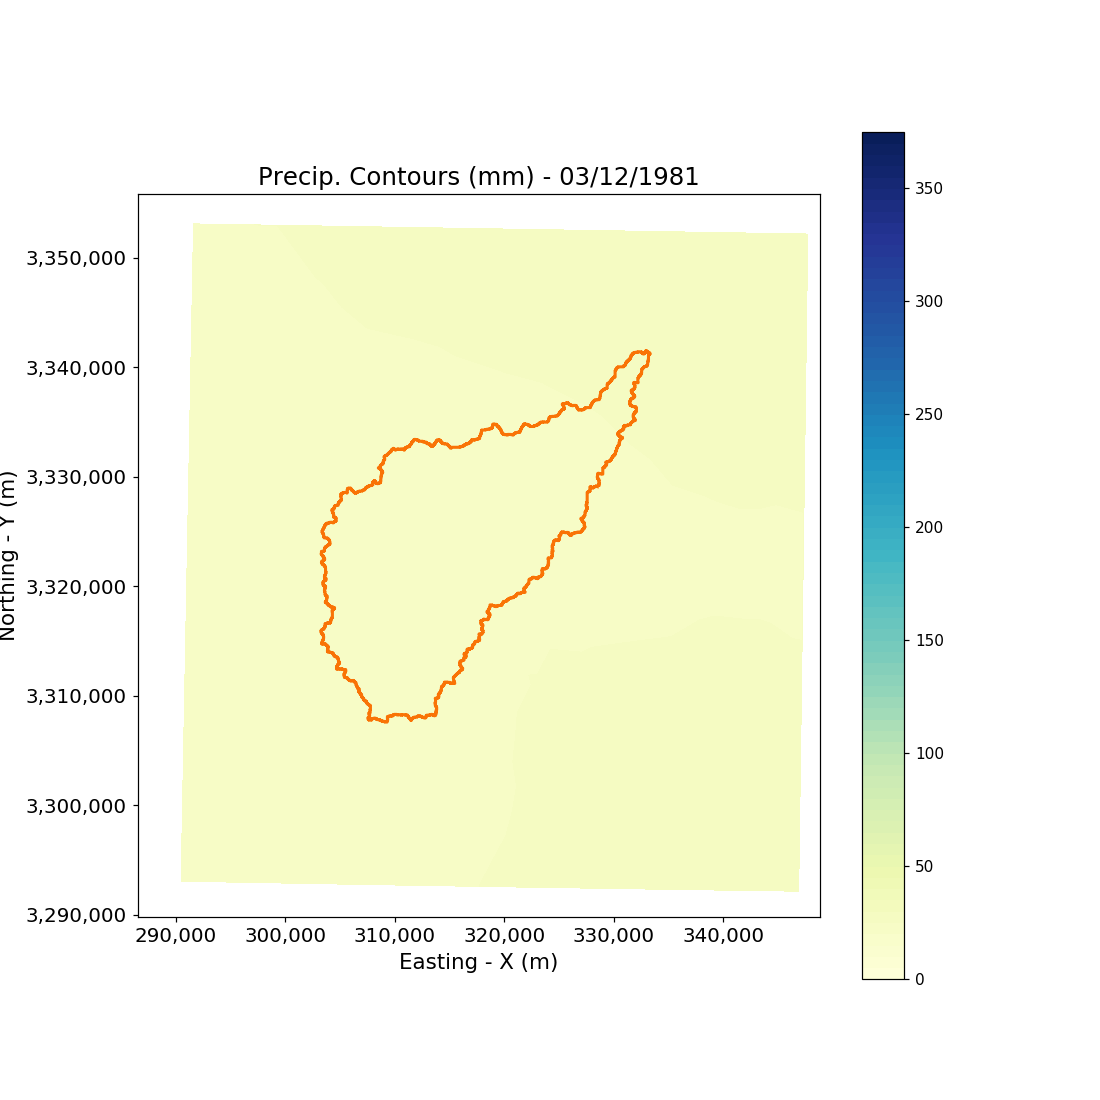

In [49]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
tcf = ax11.tricontourf( triang, TriPtsVals, levels=CInts, cmap='YlGnBu',
                        vmin=0.0, vmax=375.0 )
Fig1.colorbar(tcf, ticks=CMaps)
if tcMMDiff > 10.0:
    tcl = ax11.tricontour( triang, TriPtsVals, levels=CLines, colors='xkcd:green',
                           vmin=0.0, vmax=370.0 )
    ax11.clabel(tcl, CLines, inline=True, fmt="%d", fontsize=10 )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("Precip. Contours (mm) - %s" % tPlotDate.strftime("%m/%d/%Y"), fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

In [ ]:
NumGE20 = 0
for tDT in range( TotNumDates ):
    tPlotDate = AllDateCols[tDT]
    WorkDF = SpatTableDF[[tPlotDate]].copy()
    TriPtsVals = np.array( SpatTableDF[tPlotDate], dtype=np.float32 )
    curMean = TriPtsVals.mean()
    tcMin = TriPtsVals.min()
    tcMax = TriPtsVals.max()
    if ((curMean < COTHRESH) and (tcMax < 25.4)):
        continue
    # otherwise do the plot
    tcMMDiff = tcMax - tcMin
    TriFigName = "PrecipContours_%s.png" % tPlotDate.strftime("%Y%m%d")
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', TriFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    tcf = ax11.tricontourf( triang, TriPtsVals, levels=CInts, cmap='YlGnBu',
                            vmin=0.0, vmax=375.0 )
    Fig1.colorbar(tcf, ticks=CMaps)
    if tcMMDiff > 10.0:
        tcl = ax11.tricontour( triang, TriPtsVals, levels=CLines, colors='xkcd:green',
                               vmin=0.0, vmax=370.0 )
        ax11.clabel(tcl, CLines, inline=True, fmt="%d", fontsize=10 )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s - Max. %5.1f mm; Mean %5.1f mm" % 
                   ( tPlotDate.strftime("%m/%d/%Y"), tcMax, curMean ), fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    NumGE20 += 1
# end of for
NumGE20

### Data Postings

This type of analysis is just a series of plots with grid-cell specific values to visually look for any trends in statistical values.



In [50]:
display( HTML( gpdPolys.head().to_html() ) )

In [51]:
NumGrid, TotNumDates

(210, 3611)

#### Monthly

Go through and make DataFrames by months with all Grid locations and store these in a dictionary.

In [52]:
JanList = list()
FebList = list()
MarList = list()
AprList = list()
MayList = list()
JunList = list()
JulList = list()
AugList = list()
SepList = list()
OctList = list()
NovList = list()
DecList = list()

In [53]:
for tDT in range( TotNumDates ):
    tPlotDate = AllDateCols[tDT]
    curMonth = tPlotDate.month
    WorkDF = SpatTableDF[[tPlotDate]].copy()
    cGridIds = np.array( WorkDF.index, dtype=np.int32 )
    TriPtsVals = np.array( WorkDF[tPlotDate], dtype=np.float32 )
    cDateList = [ tPlotDate for x in range( len(WorkDF) ) ]
    cDataDict = { "DateTime" : cDateList,
                  "Grid_Id" : cGridIds,
                  "Precip_mm" : TriPtsVals, 
                }
    cDF = pd.DataFrame( data=cDataDict )
    if curMonth == 1:
        JanList.append( cDF )
    elif curMonth == 2:
        FebList.append( cDF )
    elif curMonth == 3:
        MarList.append( cDF )
    elif curMonth == 4:
        AprList.append( cDF )
    elif curMonth == 5:
        MayList.append( cDF )
    elif curMonth == 6:
        JunList.append( cDF )
    elif curMonth == 7:
        JulList.append( cDF )
    elif curMonth == 8:
        AugList.append( cDF )
    elif curMonth == 9:
        SepList.append( cDF )
    elif curMonth == 10:
        OctList.append( cDF )
    elif curMonth == 11:
        NovList.append( cDF )
    elif curMonth == 12:
        DecList.append( cDF )
# end of for

In [54]:
# make our DataFrames
JanDF = pd.concat( JanList, ignore_index=True)
FebDF = pd.concat( FebList, ignore_index=True)
MarDF = pd.concat( MarList, ignore_index=True)
AprDF = pd.concat( AprList, ignore_index=True)
MayDF = pd.concat( MayList, ignore_index=True)
JunDF = pd.concat( JunList, ignore_index=True)
JulDF = pd.concat( JulList, ignore_index=True)
AugDF = pd.concat( AugList, ignore_index=True)
SepDF = pd.concat( SepList, ignore_index=True)
OctDF = pd.concat( OctList, ignore_index=True)
NovDF = pd.concat( NovList, ignore_index=True)
DecDF = pd.concat( DecList, ignore_index=True)

In [55]:
# make a merge structure
gpdMergeDF = gpdPolys[['Index1', 'New_Area_m', 'geometry']].copy()
gpdMergeDF.columns = ["Grid_Id", "Area_m2", "geometry"]
gpdMergeDF.set_index( keys="Grid_Id", drop=True, inplace=True, verify_integrity=True )
gpdMergeDF.sort_index( axis=0, ascending=True, inplace=True )

In [56]:
mGridIds = gpdMergeDF.index.tolist()
mGridIds[:10]

[662327,
 662328,
 662329,
 662330,
 662331,
 662332,
 662333,
 662334,
 662335,
 662336]

In [57]:
display( HTML( JanDF.head().to_html() ) )

In [58]:
TestDF = JanDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )

In [59]:
checkCols = TestDF.columns.tolist()
len(checkCols), len(mGridIds)

(210, 240)

In [60]:
gpdMergeDF = gpdMergeDF[gpdMergeDF.index.isin(checkCols)]
len(gpdMergeDF)

210

In [61]:
mGridIds = gpdMergeDF.index.tolist()
mGridIds[:10]

[662328,
 662329,
 662330,
 662331,
 662332,
 662333,
 662334,
 662335,
 662336,
 662337]

In [62]:
checkCols == mGridIds

True

Now that have all the needed DataFrames created do some basic descriptive statistics and L-moments characterization to provide the values for "Data Posting". Also output these to a spreadsheet and to pickle files in case that want to use them in the future. Once the statistics are calculated and collated, then do the plots using the grid cells for the values.

Functions to calculate probability weighted moments for use in the L-moments stats

In [63]:
def LMcalcb1(npA):
    """Calculate the b1 probability weighted moment
    
    Args:
        npA (numpy, 1D array): should already be sorted in ascending order
        
    Returns:
        b1
    """
    NumA = len( npA )
    RVect = np.array( range(2, NumA + 1, 1), dtype=np.int32 )
    b1 = ( ( ( RVect - 1 )/( NumA - 1 ) ) * npA[1:] ).sum() / NumA
    return b1

In [64]:
def LMcalcb2(npA):
    """Calculate the b2 probability weighted moment
    
    Args:
        npA (numpy, 1D array): should already be sorted in ascending order
        
    Returns:
        b2
    """
    NumA = len( npA )
    RVect = np.array( range(3, NumA + 1, 1), dtype=np.int32 )
    b2 = ( ( ( ( RVect - 1 ) * ( RVect - 2 ) )/( ( NumA - 1 ) * ( NumA - 2 ) ) ) *
          npA[2:] ).sum() / NumA
    return b2

In [65]:
def LMcalcb3(npA):
    """Calculate the b3 probability weighted moment
    
    Args:
        npA (numpy, 1D array): should already be sorted in ascending order
        
    Returns:
        b3
    """
    NumA = len( npA )
    RVect = np.array( range(4, NumA + 1, 1), dtype=np.int32 )
    b3 = ( ( ( ( ( ( RVect - 1 ) * ( RVect - 2 ) ) * ( RVect - 3 ) )/( 
           ( ( NumA - 1 ) * ( NumA - 2 ) ) * ( NumA - 3 ) ) ) * npA[3:] ).sum() / 
           NumA )
    return b3

Create the GeoDataFrames for population with the desired statistics

In [66]:
NumGIDs = len( mGridIds )
NumGIDs

210

In [67]:
# create our Monthly GeoDataFrames for statistics
gpdJanDF = gpdMergeDF.copy()
gpdFebDF = gpdMergeDF.copy()
gpdMarDF = gpdMergeDF.copy()
gpdAprDF = gpdMergeDF.copy()
gpdMayDF = gpdMergeDF.copy()
gpdJunDF = gpdMergeDF.copy()
gpdJulDF = gpdMergeDF.copy()
gpdAugDF = gpdMergeDF.copy()
gpdSepDF = gpdMergeDF.copy()
gpdOctDF = gpdMergeDF.copy()
gpdNovDF = gpdMergeDF.copy()
gpdDecDF = gpdMergeDF.copy()

In [68]:
# add in the columns
gpdJanDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJanDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [69]:
# add in the columns
gpdFebDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdFebDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [70]:
# add in the columns
gpdMarDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMarDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [71]:
# add in the columns
gpdAprDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAprDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [72]:
# add in the columns
gpdMayDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdMayDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [73]:
# add in the columns
gpdJunDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJunDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [74]:
# add in the columns
gpdJulDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdJulDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [75]:
# add in the columns
gpdAugDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdAugDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [76]:
# add in the columns
gpdSepDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdSepDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [77]:
# add in the columns
gpdOctDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdOctDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [78]:
# add in the columns
gpdNovDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdNovDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

In [79]:
# add in the columns
gpdDecDF["N"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Mean"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Median"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Max"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Min"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["StDev"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Var"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_10"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_20"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_30"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_40"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_50"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_60"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_70"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_80"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_90"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["Perc_100"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["b_0"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["b_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["b_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["b_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["l_1"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["l_2"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["l_3"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["l_4"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["L-CV"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["L-Skewness"] = np.zeros( NumGIDs, dtype=np.float32 )
gpdDecDF["L-Kurtosis"] = np.zeros( NumGIDs, dtype=np.float32 )

Now populate each monthly statistics GeoDataFrame

In [80]:
DecNames = ["Perc_0", "Perc_10", "Perc_20", "Perc_30", "Perc_40", "Perc_50",
            "Perc_60", "Perc_70", "Perc_80", "Perc_90", "Perc_100" ]
ODeciles = [ 0.1 * x for x in range(11) ]
NumDecile = len( ODeciles )

In [81]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = JanDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdJanDF.at[tID, "N"] = len( SumDF )
    gpdJanDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdJanDF.at[tID, "Median"] = SumDF[tID].median()
    gpdJanDF.at[tID, "Max"] = SumDF[tID].max()
    gpdJanDF.at[tID, "Min"] = SumDF[tID].min()
    gpdJanDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdJanDF.at[tID, "Var"] = SumDF[tID].var()
    gpdJanDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdJanDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdJanDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdJanDF.at[tID, "b_0"] = b_0
    gpdJanDF.at[tID, "b_1"] = b_1
    gpdJanDF.at[tID, "b_2"] = b_2
    gpdJanDF.at[tID, "b_3"] = b_3
    gpdJanDF.at[tID, "l_1"] = l_1
    gpdJanDF.at[tID, "l_2"] = l_2
    gpdJanDF.at[tID, "l_3"] = l_3
    gpdJanDF.at[tID, "l_4"] = l_4
    gpdJanDF.at[tID, "L-CV"] = t_2
    gpdJanDF.at[tID, "L-Skewness"] = t_3
    gpdJanDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [82]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = FebDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdFebDF.at[tID, "N"] = len( SumDF )
    gpdFebDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdFebDF.at[tID, "Median"] = SumDF[tID].median()
    gpdFebDF.at[tID, "Max"] = SumDF[tID].max()
    gpdFebDF.at[tID, "Min"] = SumDF[tID].min()
    gpdFebDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdFebDF.at[tID, "Var"] = SumDF[tID].var()
    gpdFebDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdFebDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdFebDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdFebDF.at[tID, "b_0"] = b_0
    gpdFebDF.at[tID, "b_1"] = b_1
    gpdFebDF.at[tID, "b_2"] = b_2
    gpdFebDF.at[tID, "b_3"] = b_3
    gpdFebDF.at[tID, "l_1"] = l_1
    gpdFebDF.at[tID, "l_2"] = l_2
    gpdFebDF.at[tID, "l_3"] = l_3
    gpdFebDF.at[tID, "l_4"] = l_4
    gpdFebDF.at[tID, "L-CV"] = t_2
    gpdFebDF.at[tID, "L-Skewness"] = t_3
    gpdFebDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [83]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = MarDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdMarDF.at[tID, "N"] = len( SumDF )
    gpdMarDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdMarDF.at[tID, "Median"] = SumDF[tID].median()
    gpdMarDF.at[tID, "Max"] = SumDF[tID].max()
    gpdMarDF.at[tID, "Min"] = SumDF[tID].min()
    gpdMarDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdMarDF.at[tID, "Var"] = SumDF[tID].var()
    gpdMarDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdMarDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdMarDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdMarDF.at[tID, "b_0"] = b_0
    gpdMarDF.at[tID, "b_1"] = b_1
    gpdMarDF.at[tID, "b_2"] = b_2
    gpdMarDF.at[tID, "b_3"] = b_3
    gpdMarDF.at[tID, "l_1"] = l_1
    gpdMarDF.at[tID, "l_2"] = l_2
    gpdMarDF.at[tID, "l_3"] = l_3
    gpdMarDF.at[tID, "l_4"] = l_4
    gpdMarDF.at[tID, "L-CV"] = t_2
    gpdMarDF.at[tID, "L-Skewness"] = t_3
    gpdMarDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [84]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = AprDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdAprDF.at[tID, "N"] = len( SumDF )
    gpdAprDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdAprDF.at[tID, "Median"] = SumDF[tID].median()
    gpdAprDF.at[tID, "Max"] = SumDF[tID].max()
    gpdAprDF.at[tID, "Min"] = SumDF[tID].min()
    gpdAprDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdAprDF.at[tID, "Var"] = SumDF[tID].var()
    gpdAprDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdAprDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdAprDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdAprDF.at[tID, "b_0"] = b_0
    gpdAprDF.at[tID, "b_1"] = b_1
    gpdAprDF.at[tID, "b_2"] = b_2
    gpdAprDF.at[tID, "b_3"] = b_3
    gpdAprDF.at[tID, "l_1"] = l_1
    gpdAprDF.at[tID, "l_2"] = l_2
    gpdAprDF.at[tID, "l_3"] = l_3
    gpdAprDF.at[tID, "l_4"] = l_4
    gpdAprDF.at[tID, "L-CV"] = t_2
    gpdAprDF.at[tID, "L-Skewness"] = t_3
    gpdAprDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [85]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = MayDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdMayDF.at[tID, "N"] = len( SumDF )
    gpdMayDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdMayDF.at[tID, "Median"] = SumDF[tID].median()
    gpdMayDF.at[tID, "Max"] = SumDF[tID].max()
    gpdMayDF.at[tID, "Min"] = SumDF[tID].min()
    gpdMayDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdMayDF.at[tID, "Var"] = SumDF[tID].var()
    gpdMayDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdMayDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdMayDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdMayDF.at[tID, "b_0"] = b_0
    gpdMayDF.at[tID, "b_1"] = b_1
    gpdMayDF.at[tID, "b_2"] = b_2
    gpdMayDF.at[tID, "b_3"] = b_3
    gpdMayDF.at[tID, "l_1"] = l_1
    gpdMayDF.at[tID, "l_2"] = l_2
    gpdMayDF.at[tID, "l_3"] = l_3
    gpdMayDF.at[tID, "l_4"] = l_4
    gpdMayDF.at[tID, "L-CV"] = t_2
    gpdMayDF.at[tID, "L-Skewness"] = t_3
    gpdMayDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [86]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = JunDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdJunDF.at[tID, "N"] = len( SumDF )
    gpdJunDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdJunDF.at[tID, "Median"] = SumDF[tID].median()
    gpdJunDF.at[tID, "Max"] = SumDF[tID].max()
    gpdJunDF.at[tID, "Min"] = SumDF[tID].min()
    gpdJunDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdJunDF.at[tID, "Var"] = SumDF[tID].var()
    gpdJunDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdJunDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdJunDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdJunDF.at[tID, "b_0"] = b_0
    gpdJunDF.at[tID, "b_1"] = b_1
    gpdJunDF.at[tID, "b_2"] = b_2
    gpdJunDF.at[tID, "b_3"] = b_3
    gpdJunDF.at[tID, "l_1"] = l_1
    gpdJunDF.at[tID, "l_2"] = l_2
    gpdJunDF.at[tID, "l_3"] = l_3
    gpdJunDF.at[tID, "l_4"] = l_4
    gpdJunDF.at[tID, "L-CV"] = t_2
    gpdJunDF.at[tID, "L-Skewness"] = t_3
    gpdJunDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [87]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = JulDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdJulDF.at[tID, "N"] = len( SumDF )
    gpdJulDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdJulDF.at[tID, "Median"] = SumDF[tID].median()
    gpdJulDF.at[tID, "Max"] = SumDF[tID].max()
    gpdJulDF.at[tID, "Min"] = SumDF[tID].min()
    gpdJulDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdJulDF.at[tID, "Var"] = SumDF[tID].var()
    gpdJulDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdJulDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdJulDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdJulDF.at[tID, "b_0"] = b_0
    gpdJulDF.at[tID, "b_1"] = b_1
    gpdJulDF.at[tID, "b_2"] = b_2
    gpdJulDF.at[tID, "b_3"] = b_3
    gpdJulDF.at[tID, "l_1"] = l_1
    gpdJulDF.at[tID, "l_2"] = l_2
    gpdJulDF.at[tID, "l_3"] = l_3
    gpdJulDF.at[tID, "l_4"] = l_4
    gpdJulDF.at[tID, "L-CV"] = t_2
    gpdJulDF.at[tID, "L-Skewness"] = t_3
    gpdJulDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [88]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = AugDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdAugDF.at[tID, "N"] = len( SumDF )
    gpdAugDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdAugDF.at[tID, "Median"] = SumDF[tID].median()
    gpdAugDF.at[tID, "Max"] = SumDF[tID].max()
    gpdAugDF.at[tID, "Min"] = SumDF[tID].min()
    gpdAugDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdAugDF.at[tID, "Var"] = SumDF[tID].var()
    gpdAugDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdAugDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdAugDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdAugDF.at[tID, "b_0"] = b_0
    gpdAugDF.at[tID, "b_1"] = b_1
    gpdAugDF.at[tID, "b_2"] = b_2
    gpdAugDF.at[tID, "b_3"] = b_3
    gpdAugDF.at[tID, "l_1"] = l_1
    gpdAugDF.at[tID, "l_2"] = l_2
    gpdAugDF.at[tID, "l_3"] = l_3
    gpdAugDF.at[tID, "l_4"] = l_4
    gpdAugDF.at[tID, "L-CV"] = t_2
    gpdAugDF.at[tID, "L-Skewness"] = t_3
    gpdAugDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [89]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = SepDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdSepDF.at[tID, "N"] = len( SumDF )
    gpdSepDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdSepDF.at[tID, "Median"] = SumDF[tID].median()
    gpdSepDF.at[tID, "Max"] = SumDF[tID].max()
    gpdSepDF.at[tID, "Min"] = SumDF[tID].min()
    gpdSepDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdSepDF.at[tID, "Var"] = SumDF[tID].var()
    gpdSepDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdSepDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdSepDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdSepDF.at[tID, "b_0"] = b_0
    gpdSepDF.at[tID, "b_1"] = b_1
    gpdSepDF.at[tID, "b_2"] = b_2
    gpdSepDF.at[tID, "b_3"] = b_3
    gpdSepDF.at[tID, "l_1"] = l_1
    gpdSepDF.at[tID, "l_2"] = l_2
    gpdSepDF.at[tID, "l_3"] = l_3
    gpdSepDF.at[tID, "l_4"] = l_4
    gpdSepDF.at[tID, "L-CV"] = t_2
    gpdSepDF.at[tID, "L-Skewness"] = t_3
    gpdSepDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [90]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = OctDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdOctDF.at[tID, "N"] = len( SumDF )
    gpdOctDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdOctDF.at[tID, "Median"] = SumDF[tID].median()
    gpdOctDF.at[tID, "Max"] = SumDF[tID].max()
    gpdOctDF.at[tID, "Min"] = SumDF[tID].min()
    gpdOctDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdOctDF.at[tID, "Var"] = SumDF[tID].var()
    gpdOctDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdOctDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdOctDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdOctDF.at[tID, "b_0"] = b_0
    gpdOctDF.at[tID, "b_1"] = b_1
    gpdOctDF.at[tID, "b_2"] = b_2
    gpdOctDF.at[tID, "b_3"] = b_3
    gpdOctDF.at[tID, "l_1"] = l_1
    gpdOctDF.at[tID, "l_2"] = l_2
    gpdOctDF.at[tID, "l_3"] = l_3
    gpdOctDF.at[tID, "l_4"] = l_4
    gpdOctDF.at[tID, "L-CV"] = t_2
    gpdOctDF.at[tID, "L-Skewness"] = t_3
    gpdOctDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [91]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = NovDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdNovDF.at[tID, "N"] = len( SumDF )
    gpdNovDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdNovDF.at[tID, "Median"] = SumDF[tID].median()
    gpdNovDF.at[tID, "Max"] = SumDF[tID].max()
    gpdNovDF.at[tID, "Min"] = SumDF[tID].min()
    gpdNovDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdNovDF.at[tID, "Var"] = SumDF[tID].var()
    gpdNovDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdNovDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdNovDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdNovDF.at[tID, "b_0"] = b_0
    gpdNovDF.at[tID, "b_1"] = b_1
    gpdNovDF.at[tID, "b_2"] = b_2
    gpdNovDF.at[tID, "b_3"] = b_3
    gpdNovDF.at[tID, "l_1"] = l_1
    gpdNovDF.at[tID, "l_2"] = l_2
    gpdNovDF.at[tID, "l_3"] = l_3
    gpdNovDF.at[tID, "l_4"] = l_4
    gpdNovDF.at[tID, "L-CV"] = t_2
    gpdNovDF.at[tID, "L-Skewness"] = t_3
    gpdNovDF.at[tID, "L-Kurtosis"] = t_4
# end of for

In [92]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    SumDF = DecDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
    gpdDecDF.at[tID, "N"] = len( SumDF )
    gpdDecDF.at[tID, "Mean"] = SumDF[tID].mean()
    gpdDecDF.at[tID, "Median"] = SumDF[tID].median()
    gpdDecDF.at[tID, "Max"] = SumDF[tID].max()
    gpdDecDF.at[tID, "Min"] = SumDF[tID].min()
    gpdDecDF.at[tID, "StDev"] = SumDF[tID].std()
    gpdDecDF.at[tID, "Var"] = SumDF[tID].var()
    gpdDecDF.at[tID, "Skewness"] = SumDF[tID].skew()
    gpdDecDF.at[tID, "Kurtosis"] = SumDF[tID].kurt()
    RetDec = np.array( SumDF[tGID].quantile( q=ODeciles ), dtype=np.float32 )
    for jJ in range( NumDecile ):
        gpdDecDF.at[tID, DecNames[jJ]] = RetDec[jJ]
    OCalcArray = np.sort( np.array( SumDF[tGID], dtype=np.float32 ) )
    b_0 = SumDF[tID].mean()
    b_1 = LMcalcb1(OCalcArray)
    b_2 = LMcalcb2(OCalcArray)
    b_3 = LMcalcb3(OCalcArray)
    l_1 = b_0
    l_2 = (2.0 * b_1) - b_0
    l_3 = (6.0 * b_2) - (6.0 * b_1) + b_0
    l_4 = (20.0 * b_3) - (30.0 * b_2) + (12.0 * b_1) - b_0
    t_2 = l_2 / l_1
    t_3 = l_3 / l_2
    t_4 = l_4 / l_2
    gpdDecDF.at[tID, "b_0"] = b_0
    gpdDecDF.at[tID, "b_1"] = b_1
    gpdDecDF.at[tID, "b_2"] = b_2
    gpdDecDF.at[tID, "b_3"] = b_3
    gpdDecDF.at[tID, "l_1"] = l_1
    gpdDecDF.at[tID, "l_2"] = l_2
    gpdDecDF.at[tID, "l_3"] = l_3
    gpdDecDF.at[tID, "l_4"] = l_4
    gpdDecDF.at[tID, "L-CV"] = t_2
    gpdDecDF.at[tID, "L-Skewness"] = t_3
    gpdDecDF.at[tID, "L-Kurtosis"] = t_4
# end of for

Output to a spreadsheet

In [93]:
OutGSCols = gpdJanDF.columns.tolist()
del OutGSCols[1]
OutGSCols

['Area_m2',
 'N',
 'Mean',
 'Median',
 'Max',
 'Min',
 'StDev',
 'Var',
 'Skewness',
 'Kurtosis',
 'Perc_0',
 'Perc_10',
 'Perc_20',
 'Perc_30',
 'Perc_40',
 'Perc_50',
 'Perc_60',
 'Perc_70',
 'Perc_80',
 'Perc_90',
 'Perc_100',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'l_1',
 'l_2',
 'l_3',
 'l_4',
 'L-CV',
 'L-Skewness',
 'L-Kurtosis']

In [94]:
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Monthly_Stats.xlsx" ) )
with pd.ExcelWriter(OutFName) as writer:
    gpdJanDF.to_excel( writer, sheet_name="Jan", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdFebDF.to_excel( writer, sheet_name="Feb", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdMarDF.to_excel( writer, sheet_name="Mar", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdAprDF.to_excel( writer, sheet_name="Apr", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdMayDF.to_excel( writer, sheet_name="May", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdJunDF.to_excel( writer, sheet_name="Jun", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdJulDF.to_excel( writer, sheet_name="Jul", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdAugDF.to_excel( writer, sheet_name="Aug", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdSepDF.to_excel( writer, sheet_name="Sep", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdOctDF.to_excel( writer, sheet_name="Oct", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdNovDF.to_excel( writer, sheet_name="Nov", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
    gpdDecDF.to_excel( writer, sheet_name="Dec", na_rep=str(np.nan), columns=OutGSCols,
                       index=True, index_label="Grid_Id" )
# end of with    

Save to pickle files

In [95]:
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jan_Stats.pickle" ) )
gpdJanDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Feb_Stats.pickle" ) )
gpdFebDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Mar_Stats.pickle" ) )
gpdMarDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Apr_Stats.pickle" ) )
gpdAprDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_May_Stats.pickle" ) )
gpdMayDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jun_Stats.pickle" ) )
gpdJunDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jul_Stats.pickle" ) )
gpdJulDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Aug_Stats.pickle" ) )
gpdAugDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Sep_Stats.pickle" ) )
gpdSepDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Oct_Stats.pickle" ) )
gpdOctDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Nov_Stats.pickle" ) )
gpdNovDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Dec_Stats.pickle" ) )
gpdDecDF.to_pickle( OutFName )

Now do a test plot

<IPython.core.display.Javascript object>


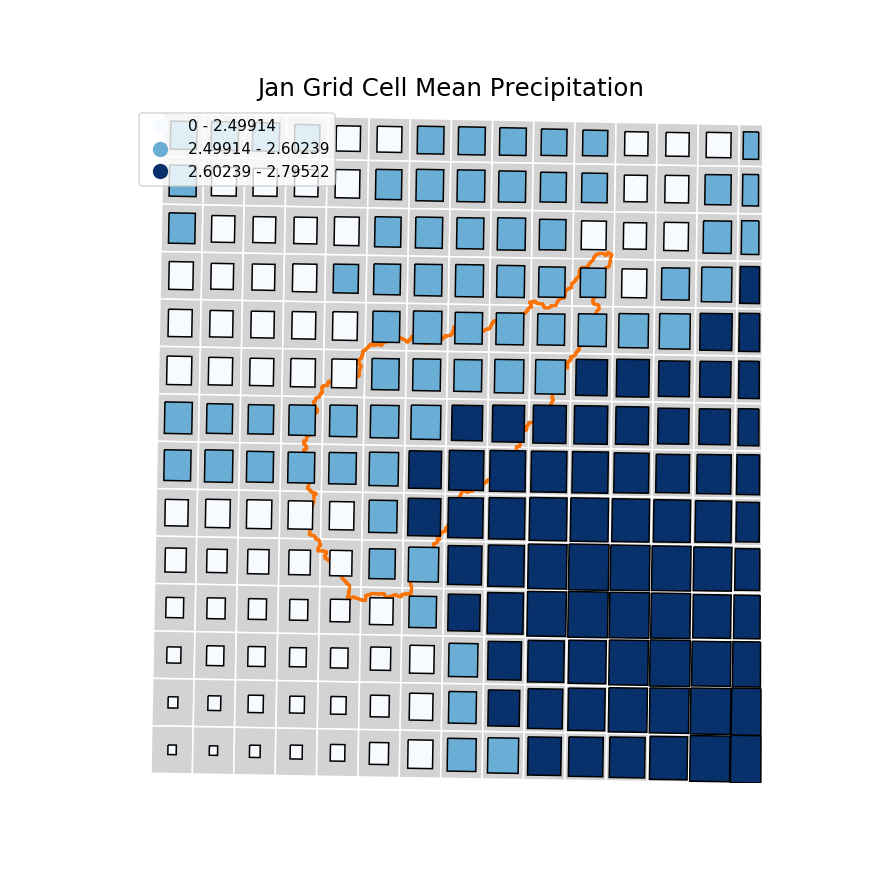

Text(0.5, 1.0, 'Jan Grid Cell Mean Precipitation')

In [96]:
Monther = "Jan"
VarType = "Mean"
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 8.0)
ax11 = Fig1.add_subplot(111)
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
gplt.cartogram( gpdJanDF, scale="Mean", hue="Mean", cmap="Blues", ax=ax11,
                legend=True, legend_var='hue', k=3 )
gplt.polyplot( gpdJanDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("%s Grid Cell %s Precipitation" % (Monther, VarType), fontsize=16 )

In [97]:
PlotColumnsList = [ "Mean", "Median", "Max", "StDev", "Skewness", "Kurtosis",
                    "l_2", "l_3", "l_4", "L-CV", "L-Skewness", "L-Kurtosis", ]
PlotCmapsList = [ "Blues", "Purples", "Greens", "Oranges", "Reds", "Greys",
                  "viridis", "plasma", "inferno", "magma", "YlOrBr", "BuPu" ]

In [98]:
NumPlotTypes = len( PlotColumnsList )
NumK = 3

In [ ]:
for iI in range( NumPlotTypes ):
    cVar = PlotColumnsList[iI]
    cCMapr = PlotCmapsList[iI]
    # do a plot for each month
    Monther = "Jan"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdJanDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdJanDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Feb"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdFebDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdFebDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Mar"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdMarDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdMarDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Apr"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdAprDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdAprDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "May"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdMayDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdMayDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Jun"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdJunDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdJunDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Jul"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdJulDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdJulDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Aug"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdAugDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdAugDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Sep"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdSepDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdSepDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Oct"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdOctDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdOctDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Nov"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdNovDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdNovDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Dec"
    cFigName = "DP_%s_%s.png" % (cVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', 
               linewidth=2, label="Watershed" )
    gplt.cartogram( gpdDecDF, scale=cVar, hue=cVar, cmap=cCMapr, ax=ax11,
                    legend=True, legend_var='hue', k=NumK )
    gplt.polyplot( gpdDecDF, ax=ax11, facecolor='lightgray', edgecolor='white' )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("%s Grid Cell Precip. %s" % (Monther, cVar), fontsize=16 )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
# end of plot for

### Correlation Functions, Covariance Functions, and Variograms

This portion of the analysis is borrowed from the equivalent named section in Isaaks and Srivastava. It involves make three plots for each month.

1. Correlogram
2. Covariance Function
3. Variogram or moment of inertia offset plot

Moment of inertia: calculated for each offset $h$.

\begin{equation*}
    \gamma \left( h \right) = \frac{1}{2N} \sum_{i=1}^{N} \left( x_{i} - y_{i} \right)^{2}
\end{equation*}

First determine the offsets from each grid point

In [99]:
display( HTML( GridDF.head().to_html() ) )

In [100]:
OffsetDict = dict()

In [101]:
for iI in range( NumGIDs ):
    tID = mGridIds[iI]
    cRow = GridDF[GridDF["Grid_Index"] == tID ]
    cUTMx = float( cRow['utm_x'] )
    cUTMy = float( cRow['utm_y'] )
    LocalDict = dict()
    for jJ in range( NumGIDs ):
        nID = mGridIds[jJ]
        nRow = GridDF[GridDF["Grid_Index"] == nID ]
        nUTMx = float( nRow['utm_x'] )
        nUTMy = float( nRow['utm_y'] )
        absDist = sqrt( pow( (cUTMx - nUTMx), 2.0 ) + pow( ( cUTMy - nUTMy ), 2.0 ) )
        LocalDict[nID] = absDist
    # end of inner for
    OffsetDict[tID] = LocalDict
# end of outer for

Determine our grid cell to grid cell combinations

In [102]:
CompList = list( itertools.combinations( mGridIds, 2 ) )

In [103]:
NumComps = len( CompList )
NumComps

21945

Need to process through each month and get the correlation, covariance, moment of inertia, and offset among each pair of grid cells. Do this by month and then by grid cell combination.

In [104]:
cPivDF = JanDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
JanCovDF = cPivDF.cov()
JanCorrPDF = cPivDF.corr( method='pearson' )
JanCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( JanCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( JanCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( JanCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
JanCCVDF = pd.DataFrame( data=DataDict )

In [105]:
cPivDF = FebDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
FebCovDF = cPivDF.cov()
FebCorrPDF = cPivDF.corr( method='pearson' )
FebCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( FebCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( FebCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( FebCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
FebCCVDF = pd.DataFrame( data=DataDict )

In [106]:
cPivDF = MarDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
MarCovDF = cPivDF.cov()
MarCorrPDF = cPivDF.corr( method='pearson' )
MarCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( MarCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( MarCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( MarCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
MarCCVDF = pd.DataFrame( data=DataDict )

In [107]:
cPivDF = AprDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
AprCovDF = cPivDF.cov()
AprCorrPDF = cPivDF.corr( method='pearson' )
AprCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( AprCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( AprCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( AprCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
AprCCVDF = pd.DataFrame( data=DataDict )

In [108]:
cPivDF = MayDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
MayCovDF = cPivDF.cov()
MayCorrPDF = cPivDF.corr( method='pearson' )
MayCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( MayCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( MayCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( MayCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
MayCCVDF = pd.DataFrame( data=DataDict )

In [109]:
cPivDF = JunDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
JunCovDF = cPivDF.cov()
JunCorrPDF = cPivDF.corr( method='pearson' )
JunCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( JunCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( JunCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( JunCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
JunCCVDF = pd.DataFrame( data=DataDict )

In [110]:
cPivDF = JulDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
JulCovDF = cPivDF.cov()
JulCorrPDF = cPivDF.corr( method='pearson' )
JulCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( JulCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( JulCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( JulCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
JulCCVDF = pd.DataFrame( data=DataDict )

In [111]:
cPivDF = AugDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
AugCovDF = cPivDF.cov()
AugCorrPDF = cPivDF.corr( method='pearson' )
AugCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( AugCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( AugCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( AugCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
AugCCVDF = pd.DataFrame( data=DataDict )

In [112]:
cPivDF = SepDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
SepCovDF = cPivDF.cov()
SepCorrPDF = cPivDF.corr( method='pearson' )
SepCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( SepCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( SepCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( SepCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
SepCCVDF = pd.DataFrame( data=DataDict )

In [113]:
cPivDF = OctDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
OctCovDF = cPivDF.cov()
OctCorrPDF = cPivDF.corr( method='pearson' )
OctCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( OctCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( OctCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( OctCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
OctCCVDF = pd.DataFrame( data=DataDict )

In [114]:
cPivDF = NovDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
NovCovDF = cPivDF.cov()
NovCorrPDF = cPivDF.corr( method='pearson' )
NovCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( NovCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( NovCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( NovCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
NovCCVDF = pd.DataFrame( data=DataDict )

In [115]:
cPivDF = DecDF.pivot( index='DateTime', columns='Grid_Id', values='Precip_mm' )
NumMo = len( cPivDF )
DecCovDF = cPivDF.cov()
DecCorrPDF = cPivDF.corr( method='pearson' )
DecCorrSDF = cPivDF.corr( method='spearman' )
# create our numpy arrays
DistH = np.zeros( NumComps, dtype=np.float32 )
CorrP = np.zeros( NumComps, dtype=np.float32 )
CorrS = np.zeros( NumComps, dtype=np.float32 )
Cov = np.zeros( NumComps, dtype=np.float32 )
MoI = np.zeros( NumComps, dtype=np.float32 )
iCmp = 0
for cPr in CompList:
    # get the distance for the pair
    distDict = OffsetDict[cPr[0]]
    hCurr = distDict[cPr[1]]
    # get the values for calculating moment of inertia
    xArr = cPivDF[cPr[0]]
    yArr = cPivDF[cPr[1]]
    # calculate MoI
    cMoI = (np.power( xArr - yArr, 2.0 )).sum() * ( 1.0 / ( 2.0 * NumMo ) )
    # next pull out our values for correlation and covariance
    cCorrP = float( DecCorrPDF.at[cPr[0], cPr[1]] )
    cCorrS = float( DecCorrSDF.at[cPr[0], cPr[1]] )
    cCov = float( DecCovDF.at[cPr[0], cPr[1]] )
    # assign our values to vectors
    DistH[iCmp] = hCurr
    CorrP[iCmp] = cCorrP
    CorrS[iCmp] = cCorrS
    Cov[iCmp] = cCov
    MoI[iCmp] = cMoI
    iCmp += 1
# end of for
# make a DataFrame
DataDict = { "h_offset" : DistH,
             "Corr_P" : CorrP,
             "Corr_S" : CorrS,
             "Cov" : Cov,
             "MoI" : MoI,
           }
DecCCVDF = pd.DataFrame( data=DataDict )

Output to Excel and pickle files for later use

In [116]:
OutCols2 = [ "h_offset", "Corr_P", "Corr_S", "Cov", "MoI" ]

In [117]:
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Monthly_CorCovVar.xlsx" ) )
with pd.ExcelWriter(OutFName) as writer:
    JanCCVDF.to_excel( writer, sheet_name="Jan_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    JanCovDF.to_excel( writer, sheet_name="Jan_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    JanCorrPDF.to_excel( writer, sheet_name="Jan_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    JanCorrSDF.to_excel( writer, sheet_name="Jan_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    FebCCVDF.to_excel( writer, sheet_name="Feb_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    FebCovDF.to_excel( writer, sheet_name="Feb_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    FebCorrPDF.to_excel( writer, sheet_name="Feb_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    FebCorrSDF.to_excel( writer, sheet_name="Feb_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    MarCCVDF.to_excel( writer, sheet_name="Mar_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    MarCovDF.to_excel( writer, sheet_name="Mar_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    MarCorrPDF.to_excel( writer, sheet_name="Mar_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    MarCorrSDF.to_excel( writer, sheet_name="Mar_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    AprCCVDF.to_excel( writer, sheet_name="Apr_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    AprCovDF.to_excel( writer, sheet_name="Apr_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    AprCorrPDF.to_excel( writer, sheet_name="Apr_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    AprCorrSDF.to_excel( writer, sheet_name="Apr_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    MayCCVDF.to_excel( writer, sheet_name="May_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    MayCovDF.to_excel( writer, sheet_name="May_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    MayCorrPDF.to_excel( writer, sheet_name="May_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    MayCorrSDF.to_excel( writer, sheet_name="May_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    JunCCVDF.to_excel( writer, sheet_name="Jun_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    JunCovDF.to_excel( writer, sheet_name="Jun_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    JunCorrPDF.to_excel( writer, sheet_name="Jun_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    JunCorrSDF.to_excel( writer, sheet_name="Jun_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    JulCCVDF.to_excel( writer, sheet_name="Jul_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    JulCovDF.to_excel( writer, sheet_name="Jul_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    JulCorrPDF.to_excel( writer, sheet_name="Jul_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    JulCorrSDF.to_excel( writer, sheet_name="Jul_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    AugCCVDF.to_excel( writer, sheet_name="Aug_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    AugCovDF.to_excel( writer, sheet_name="Aug_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    AugCorrPDF.to_excel( writer, sheet_name="Aug_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    AugCorrSDF.to_excel( writer, sheet_name="Aug_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    SepCCVDF.to_excel( writer, sheet_name="Sep_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    SepCovDF.to_excel( writer, sheet_name="Sep_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    SepCorrPDF.to_excel( writer, sheet_name="Sep_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    SepCorrSDF.to_excel( writer, sheet_name="Sep_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    OctCCVDF.to_excel( writer, sheet_name="Oct_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    OctCovDF.to_excel( writer, sheet_name="Oct_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    OctCorrPDF.to_excel( writer, sheet_name="Oct_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    OctCorrSDF.to_excel( writer, sheet_name="Oct_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    NovCCVDF.to_excel( writer, sheet_name="Nov_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    NovCovDF.to_excel( writer, sheet_name="Nov_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    NovCorrPDF.to_excel( writer, sheet_name="Nov_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    NovCorrSDF.to_excel( writer, sheet_name="Nov_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    DecCCVDF.to_excel( writer, sheet_name="Dec_HOff", na_rep=str(np.nan), columns=OutCols2,
                         index=False )
    DecCovDF.to_excel( writer, sheet_name="Dec_Cov", na_rep=str(np.nan), 
                      index=True, index_label="Grid_Id" )
    DecCorrPDF.to_excel( writer, sheet_name="Dec_CorrP", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
    DecCorrSDF.to_excel( writer, sheet_name="Dec_CorrS", na_rep=str(np.nan), 
                         index=True, index_label="Grid_Id" )
# end of with    

In [118]:
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jan_CorCovVar.pickle" ) )
JanCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Feb_CorCovVar.pickle" ) )
FebCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Mar_CorCovVar.pickle" ) )
MarCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Apr_CorCovVar.pickle" ) )
AprCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_May_CorCovVar.pickle" ) )
MayCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jun_CorCovVar.pickle" ) )
JunCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jul_CorCovVar.pickle" ) )
JulCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Aug_CorCovVar.pickle" ) )
AugCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Sep_CorCovVar.pickle" ) )
SepCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Oct_CorCovVar.pickle" ) )
OctCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Nov_CorCovVar.pickle" ) )
NovCCVDF.to_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Dec_CorCovVar.pickle" ) )
DecCCVDF.to_pickle( OutFName )

Make the correlogram, covariance by offset, and variogram plots

In [ ]:
"""
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jan_CorCovVar.pickle" ) )
JanCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Feb_CorCovVar.pickle" ) )
FebCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Mar_CorCovVar.pickle" ) )
MarCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Apr_CorCovVar.pickle" ) )
AprCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_May_CorCovVar.pickle" ) )
MayCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jun_CorCovVar.pickle" ) )
JunCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Jul_CorCovVar.pickle" ) )
JulCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Aug_CorCovVar.pickle" ) )
AugCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Sep_CorCovVar.pickle" ) )
SepCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Oct_CorCovVar.pickle" ) )
OctCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Nov_CorCovVar.pickle" ) )
NovCCVDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( OUT_DIR, "Grid_Dec_CorCovVar.pickle" ) )
DecCCVDF = pd.read_pickle( OutFName )
"""

In [124]:
display( HTML(JanCCVDF.head().to_html() ) )

Do some sample plots

<IPython.core.display.Javascript object>


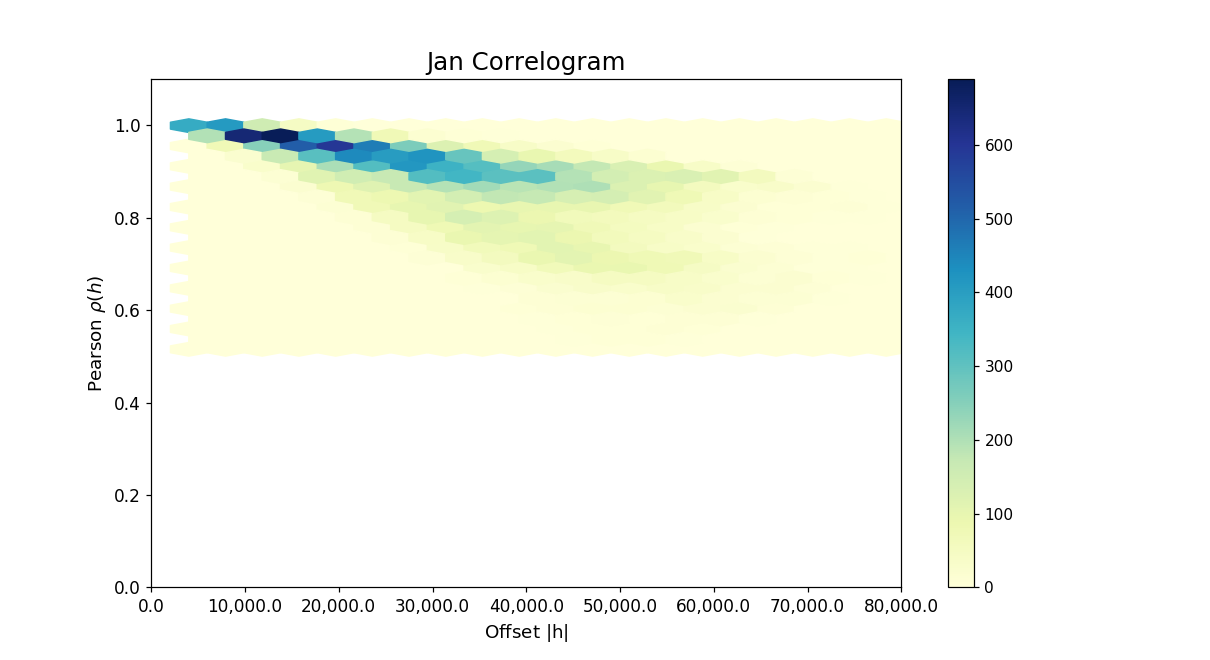

In [155]:
Monther = "Jan"
Fig1 = plt.figure()
Fig1.set_size_inches(11.0, 6.0)
ax11 = Fig1.add_subplot(111)
JanCCVDF.plot.hexbin( x="h_offset", y="Corr_P", gridsize=20, cmap="YlGnBu", ax=ax11 )
ax11.set_ylim( (0.0, 1.1) )
ax11.set_xlim( (0.0, 80000) )
ax11.set_title("%s Correlogram" % Monther, fontsize=16)
ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
ax11.set_ylabel(r'Pearson $\rho \left( h \right)$', fontsize=12)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

<IPython.core.display.Javascript object>


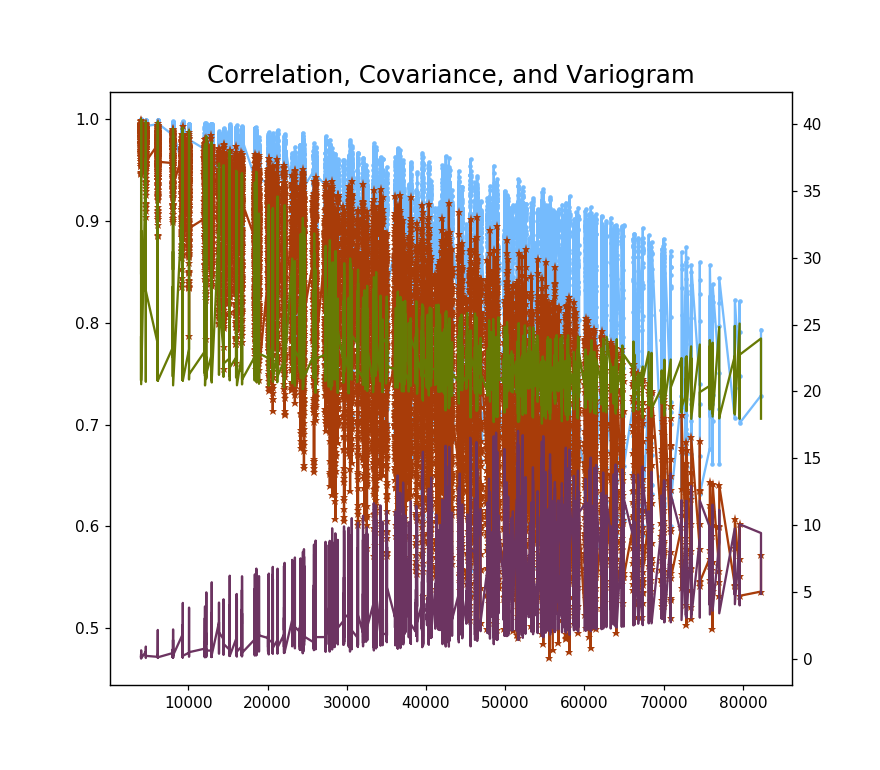

Text(0.5, 1.0, 'Correlation, Covariance, and Variogram')

In [127]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 7.0)
ax11 = Fig1.add_subplot(111)
ax21 = ax11.twinx()
corrpl, = ax11.plot( JanCCVDF[OutCols2[0]], JanCCVDF[OutCols2[1]], marker='.', 
                     markeredgecolor='none', color="xkcd:sky blue", linestyle='-'  )
corrsl, = ax11.plot( JanCCVDF[OutCols2[0]], JanCCVDF[OutCols2[2]], marker='*', 
                     markeredgecolor='none', color="xkcd:rust", linestyle='-'  )
covl, = ax21.plot( JanCCVDF[OutCols2[0]], JanCCVDF[OutCols2[3]], marker='+', 
                     markeredgecolor='none', color="xkcd:olive green", linestyle='-'  )
moil, = ax21.plot( JanCCVDF[OutCols2[0]], JanCCVDF[OutCols2[4]], marker='x', 
                     markeredgecolor='none', color="xkcd:grape", linestyle='-'  )
ax11.set_title("Correlation, Covariance, and Variogram", fontsize=16)

Loop through the variables and output our plots

In [166]:
CmapDict = { "Corr_P" : ["YlGnBu", "Correlogram", r'Pearson $\rho \left( h \right)$'], 
             "Corr_S" : ["Blues", "Rank Correlogram", r'Spearman $\rho \left( h \right)$'],
             "Cov" : ["YlOrRd", "Covariance", r'C$\left( h \right)$'],
             "MoI" : ["PuBuGn", "Variogram", r'$\gamma \left( h \right)$'],
           }

<IPython.core.display.Javascript object>


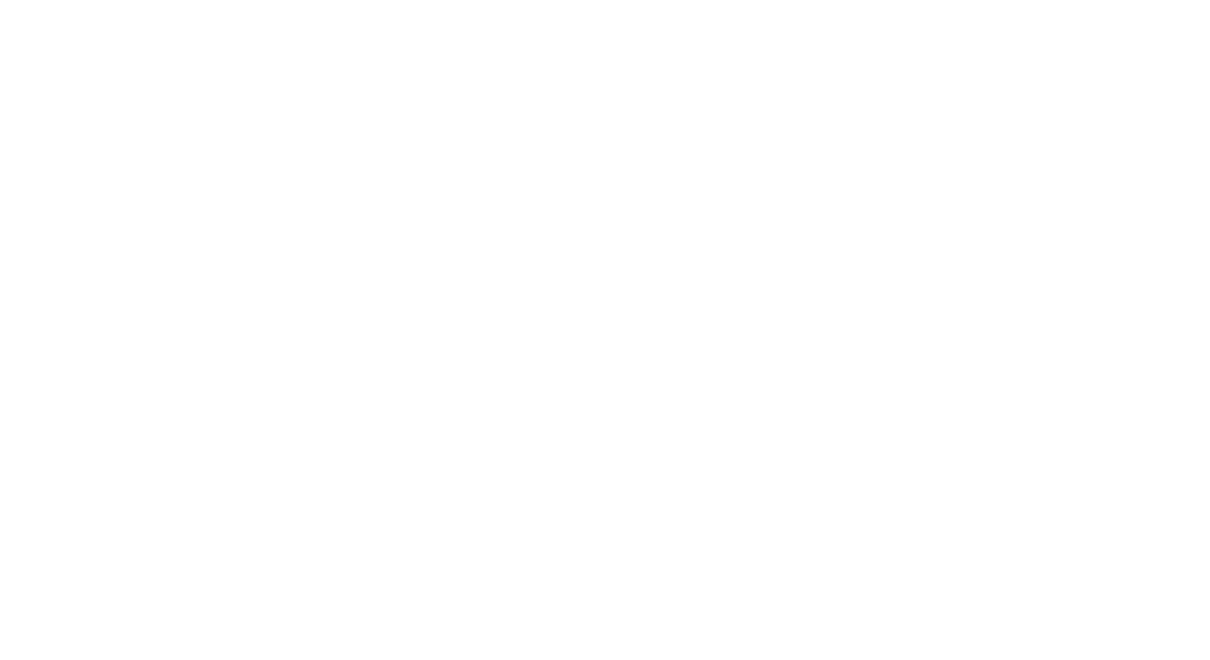

<IPython.core.display.Javascript object>


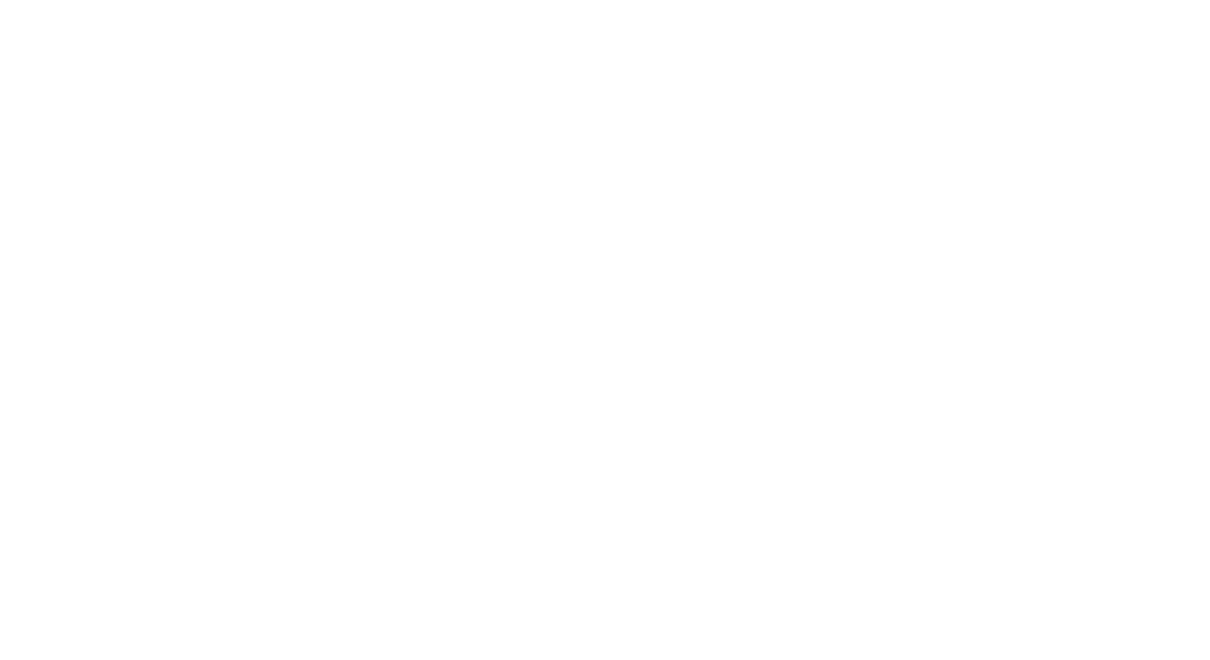

<IPython.core.display.Javascript object>


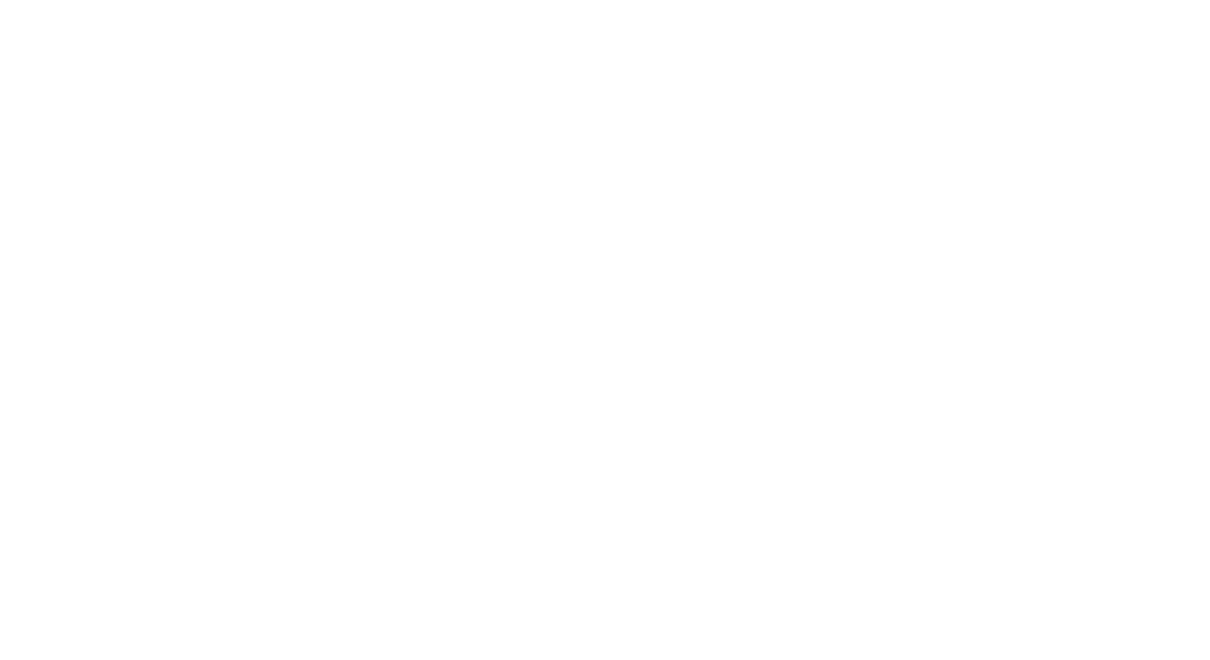

<IPython.core.display.Javascript object>


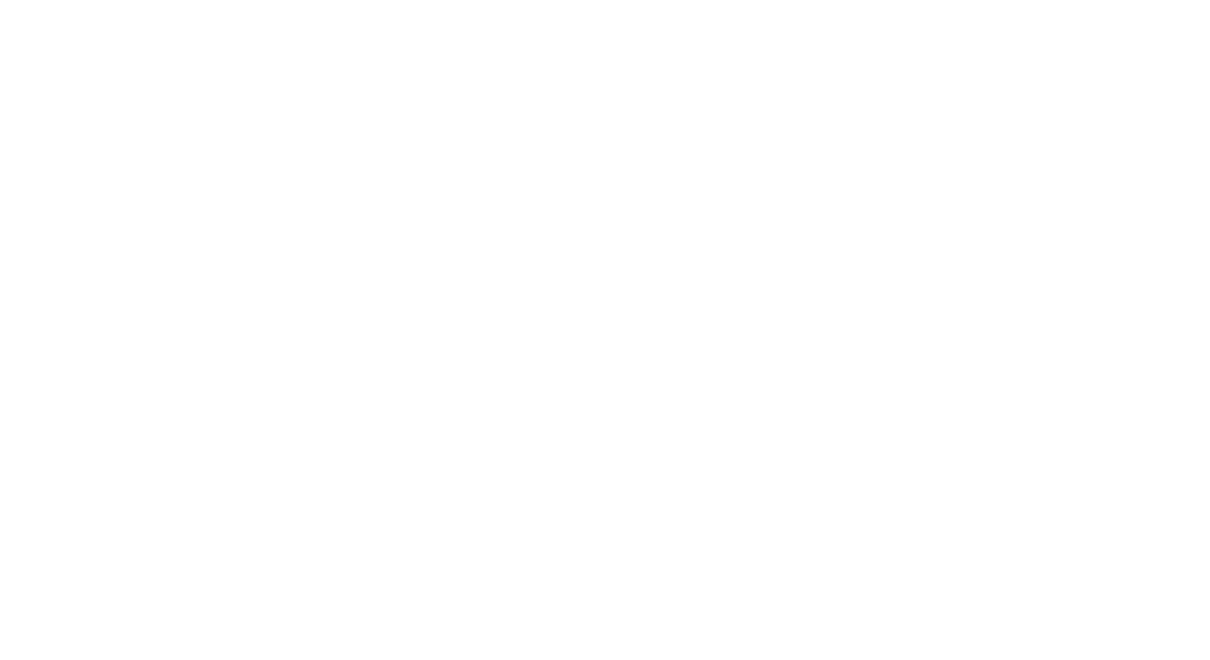

<IPython.core.display.Javascript object>


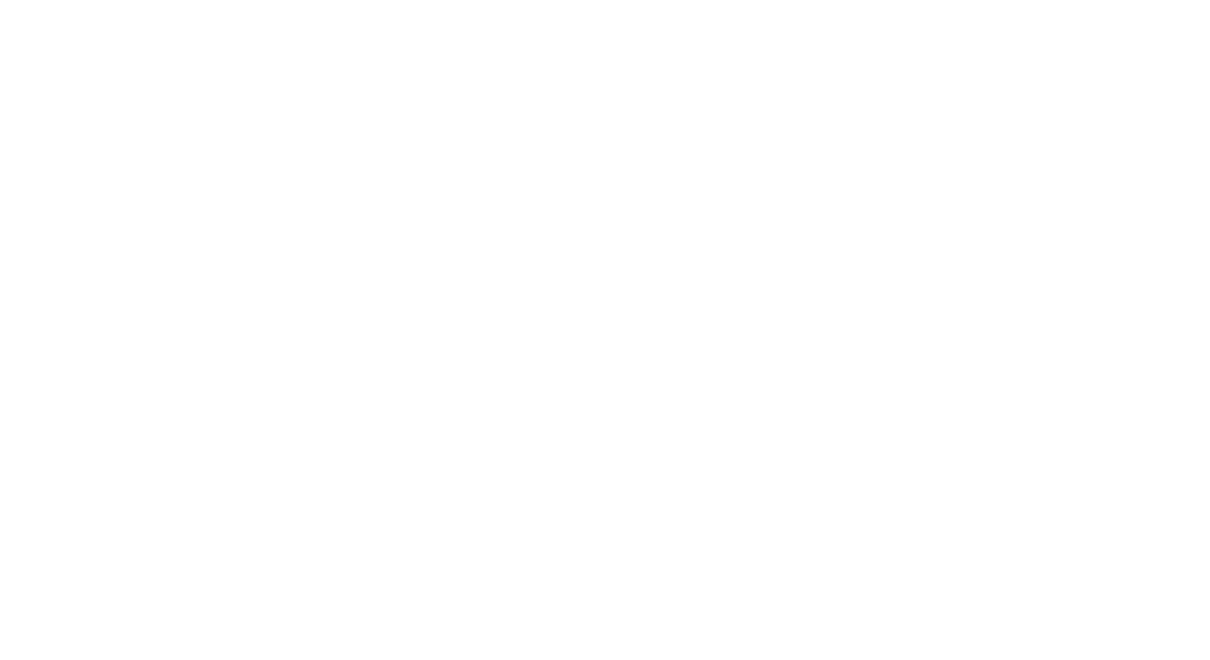

<IPython.core.display.Javascript object>


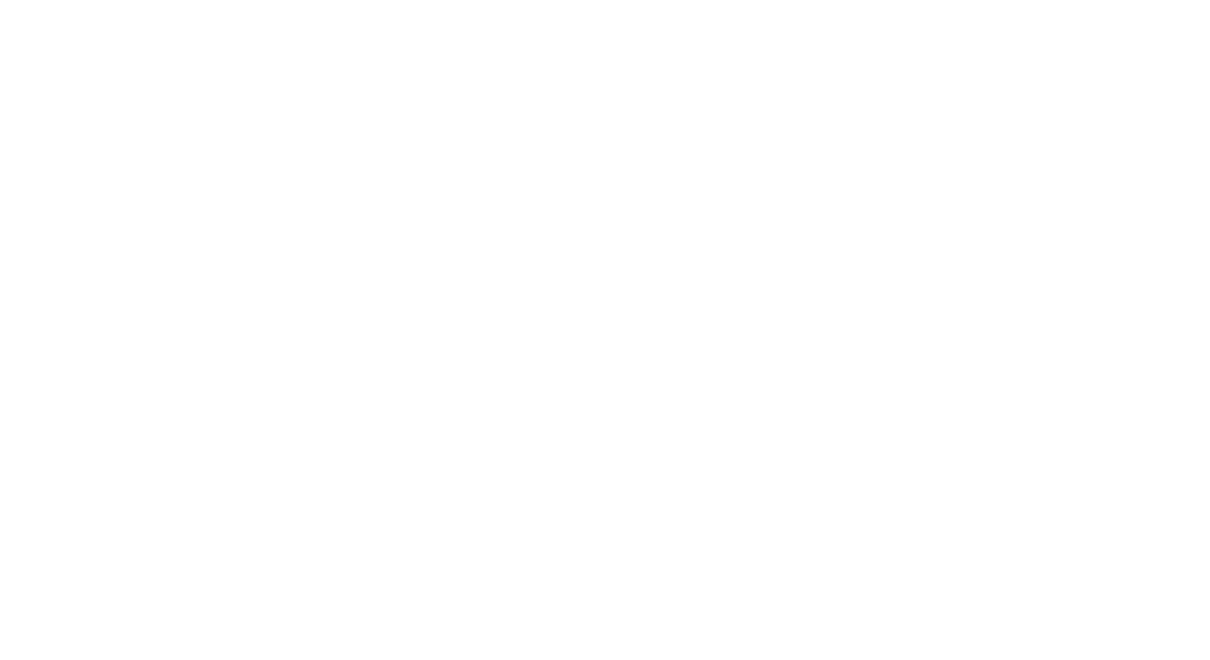

<IPython.core.display.Javascript object>


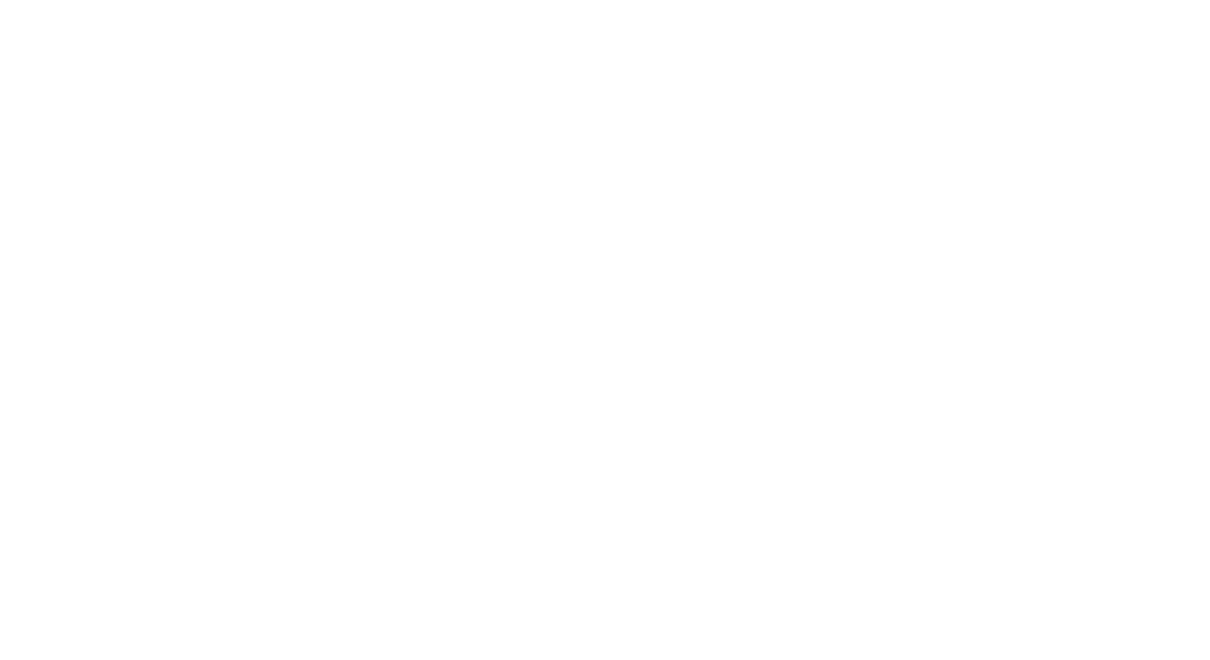

<IPython.core.display.Javascript object>


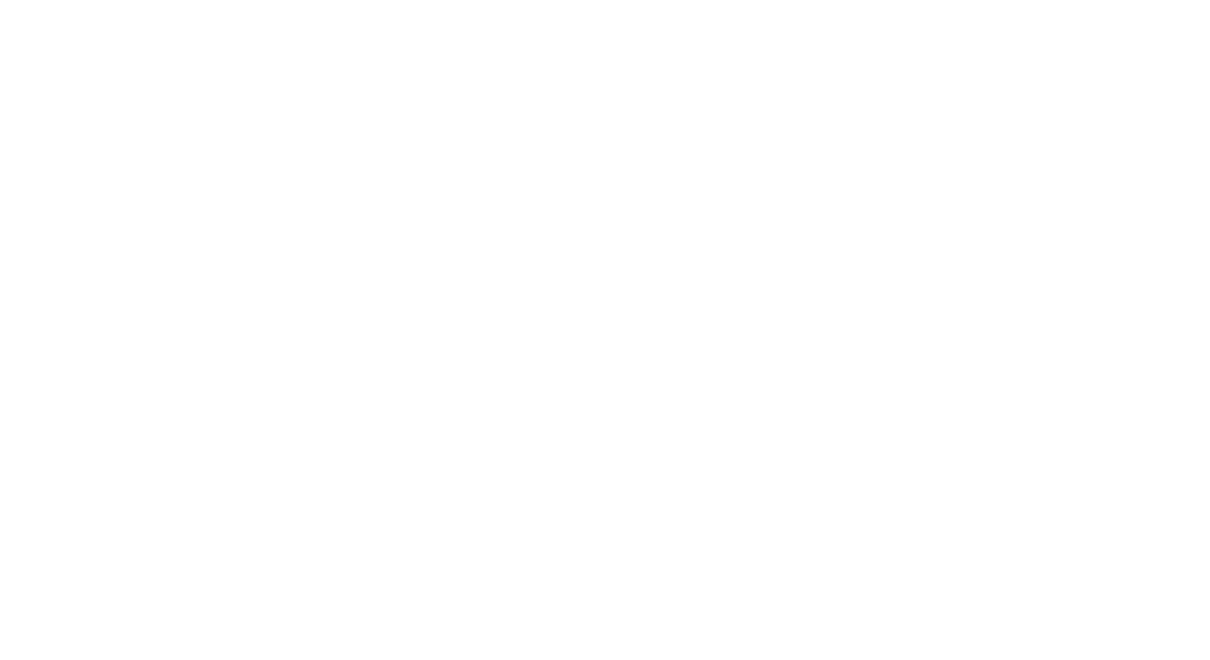

<IPython.core.display.Javascript object>


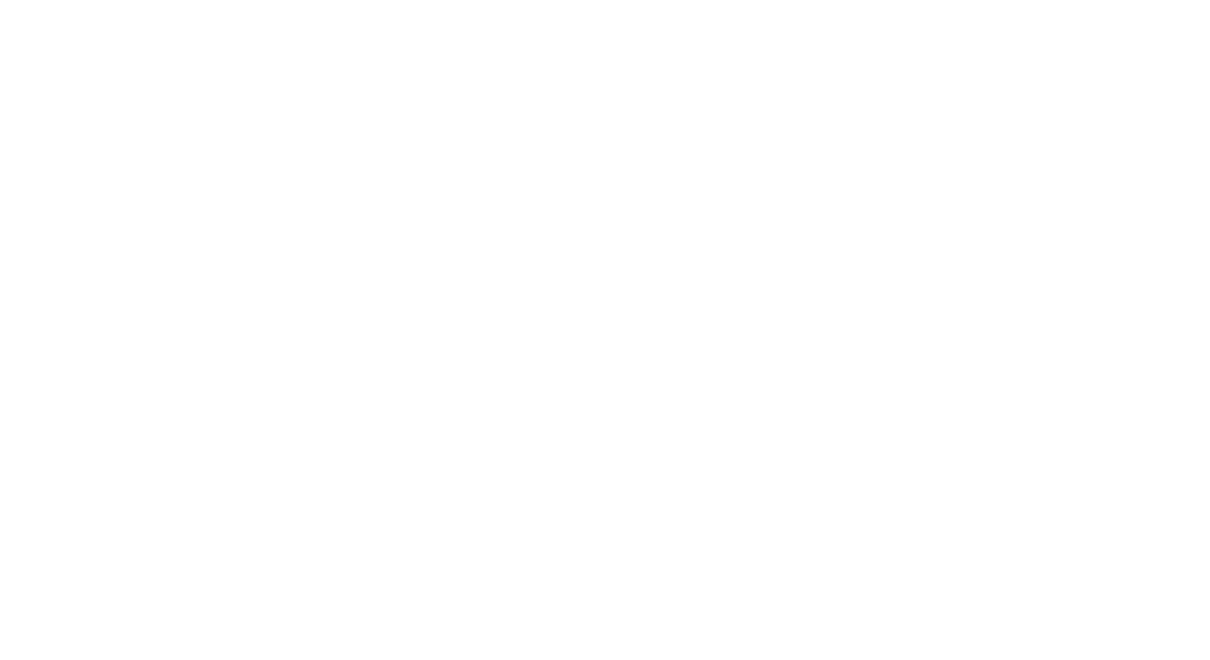

<IPython.core.display.Javascript object>


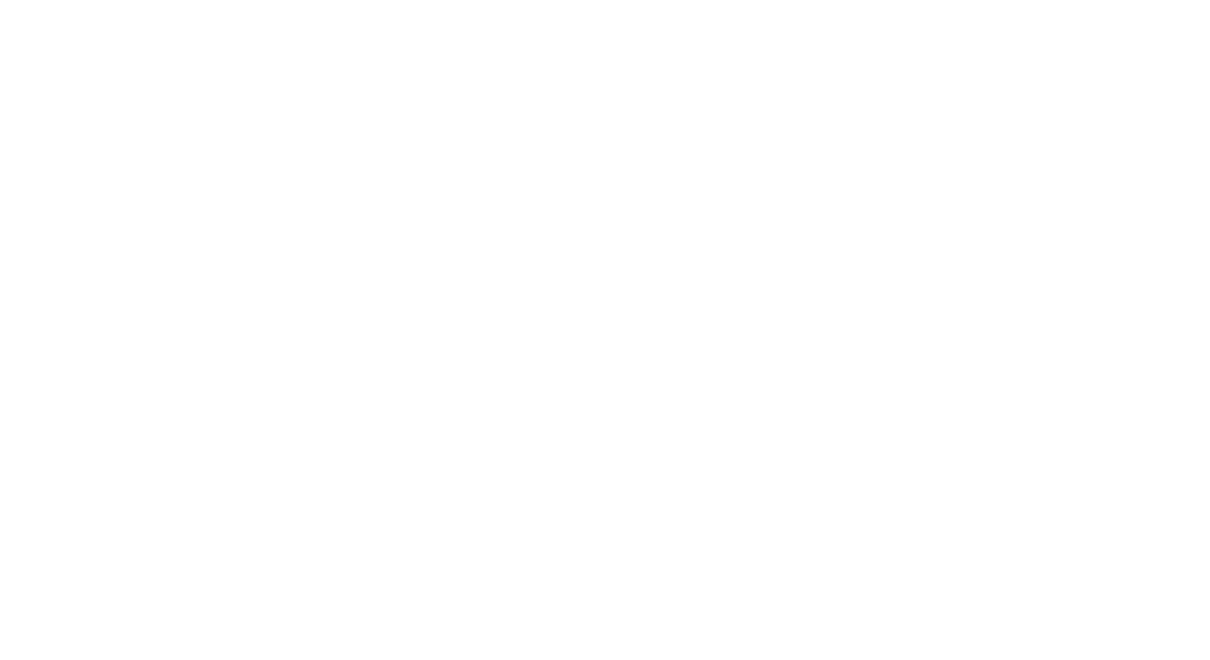

<IPython.core.display.Javascript object>


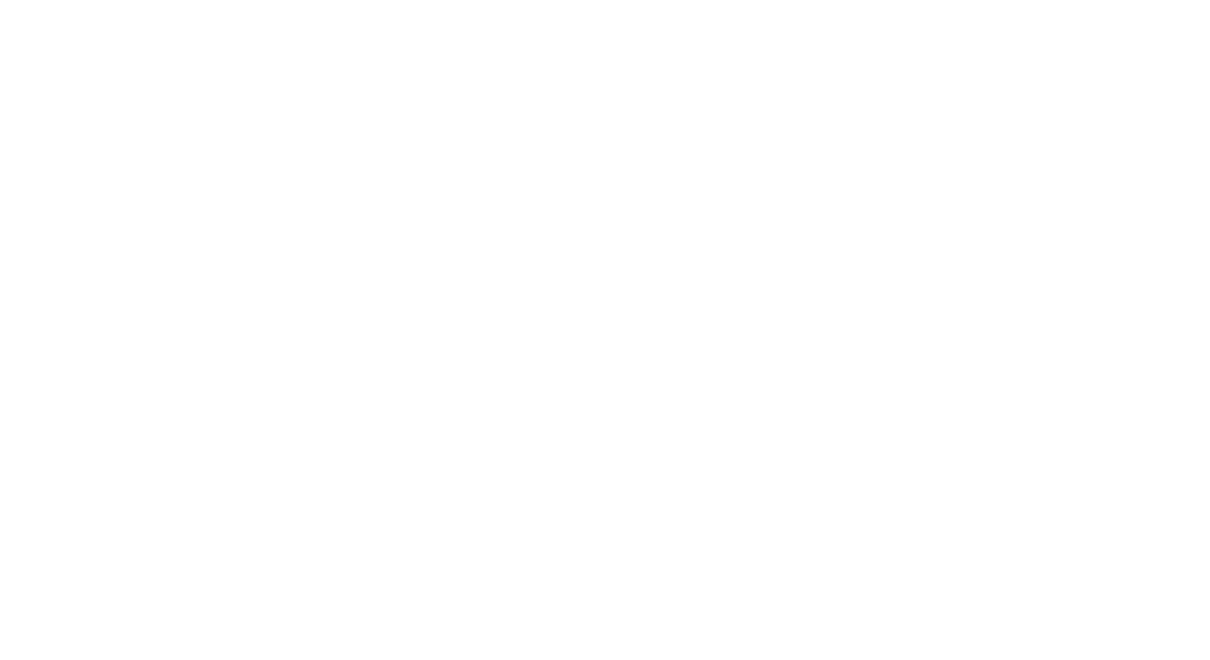

<IPython.core.display.Javascript object>


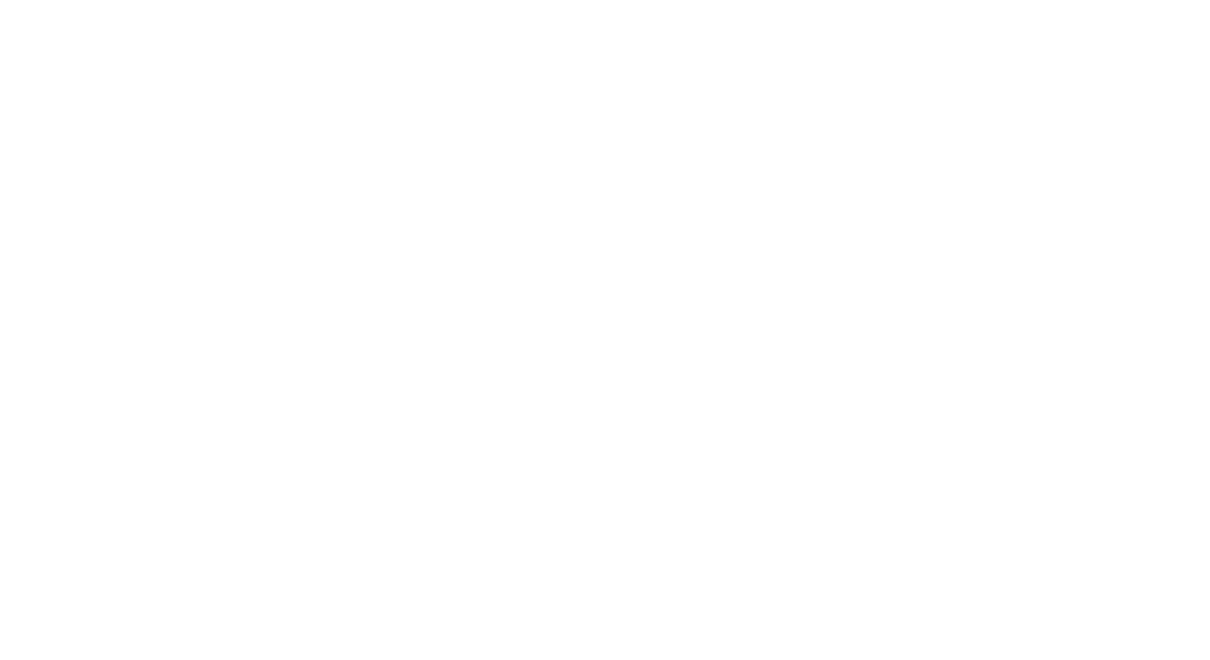

<IPython.core.display.Javascript object>


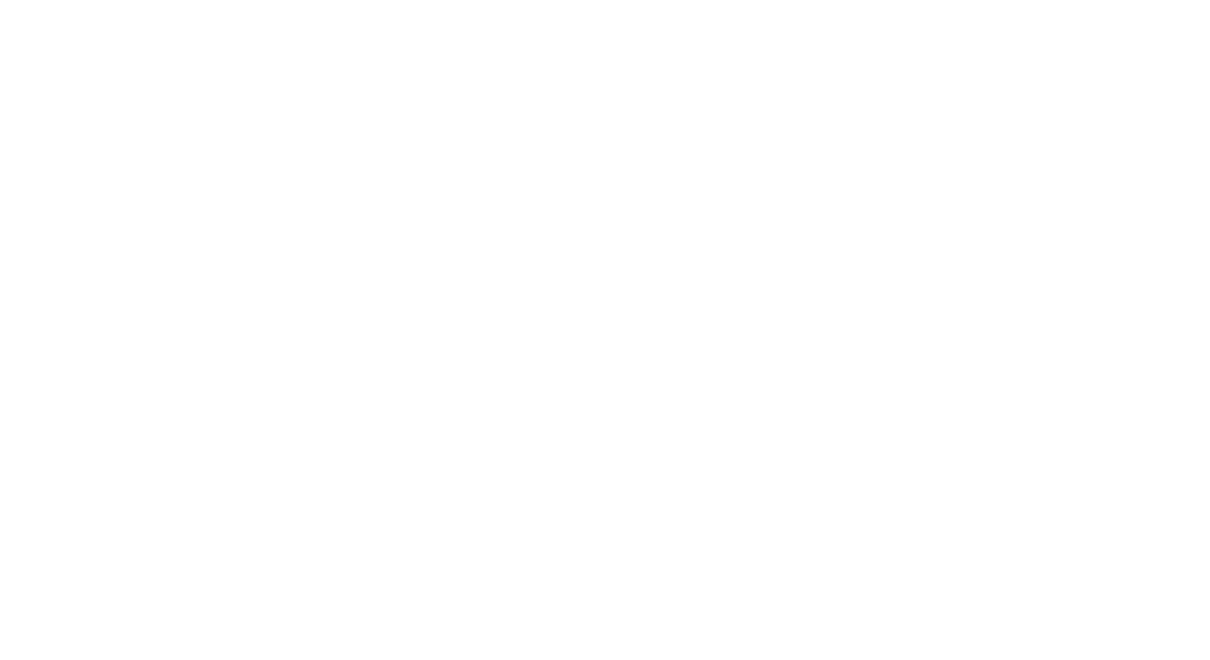

<IPython.core.display.Javascript object>


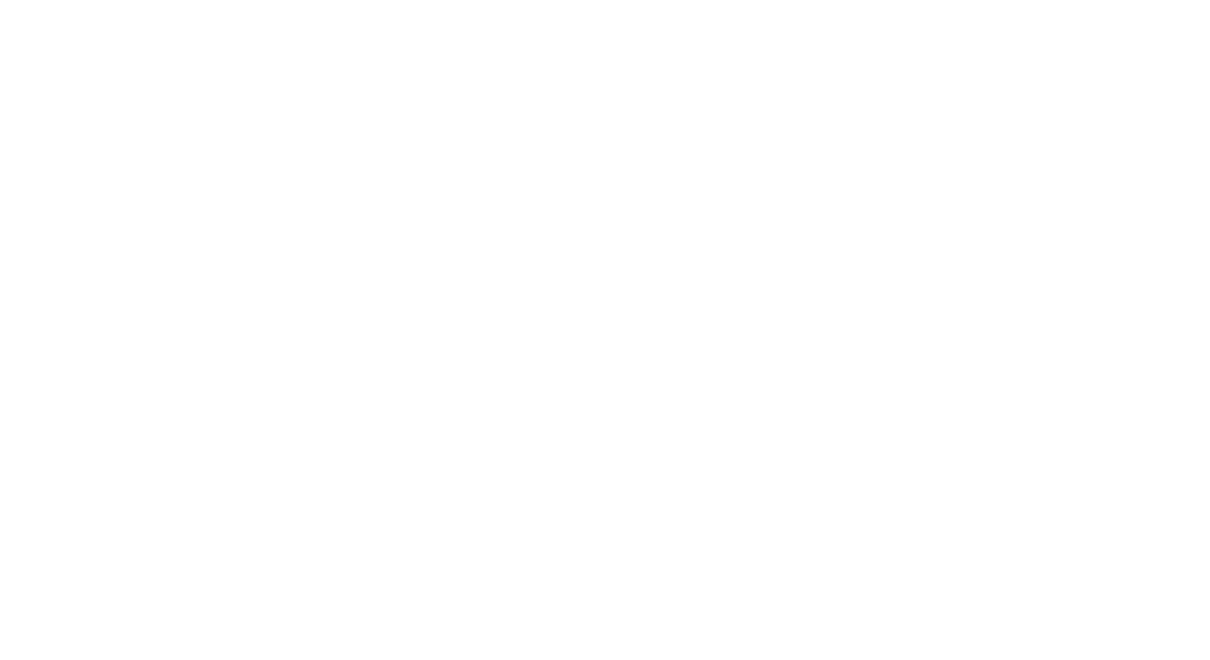

<IPython.core.display.Javascript object>


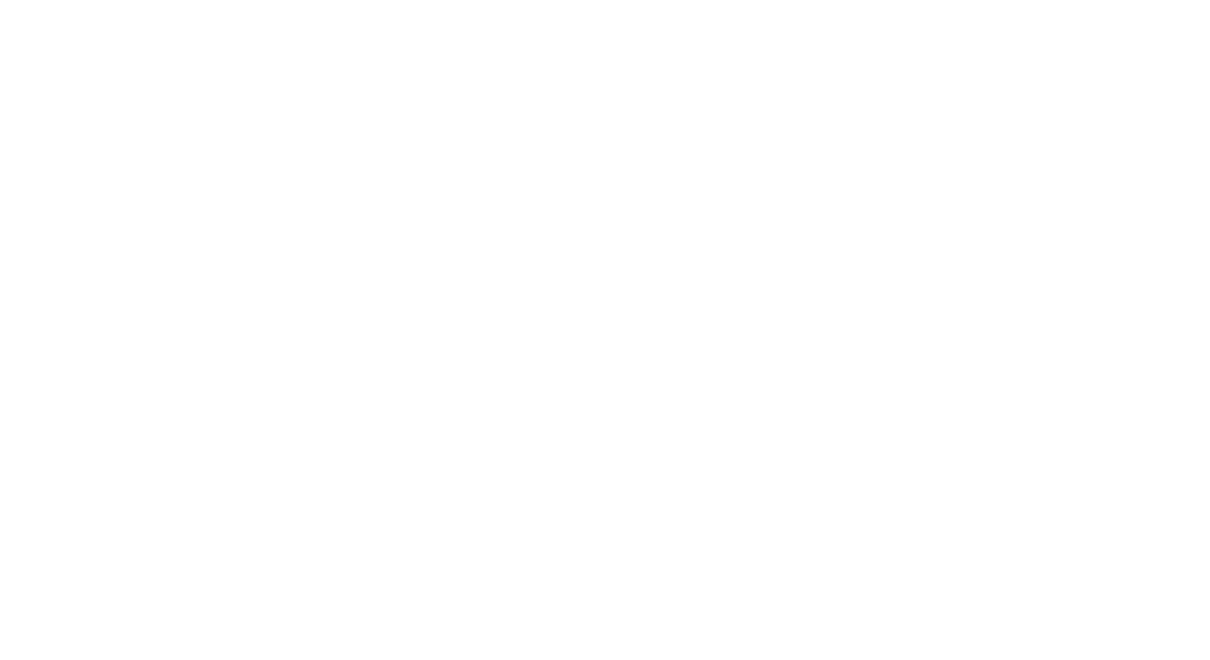

<IPython.core.display.Javascript object>


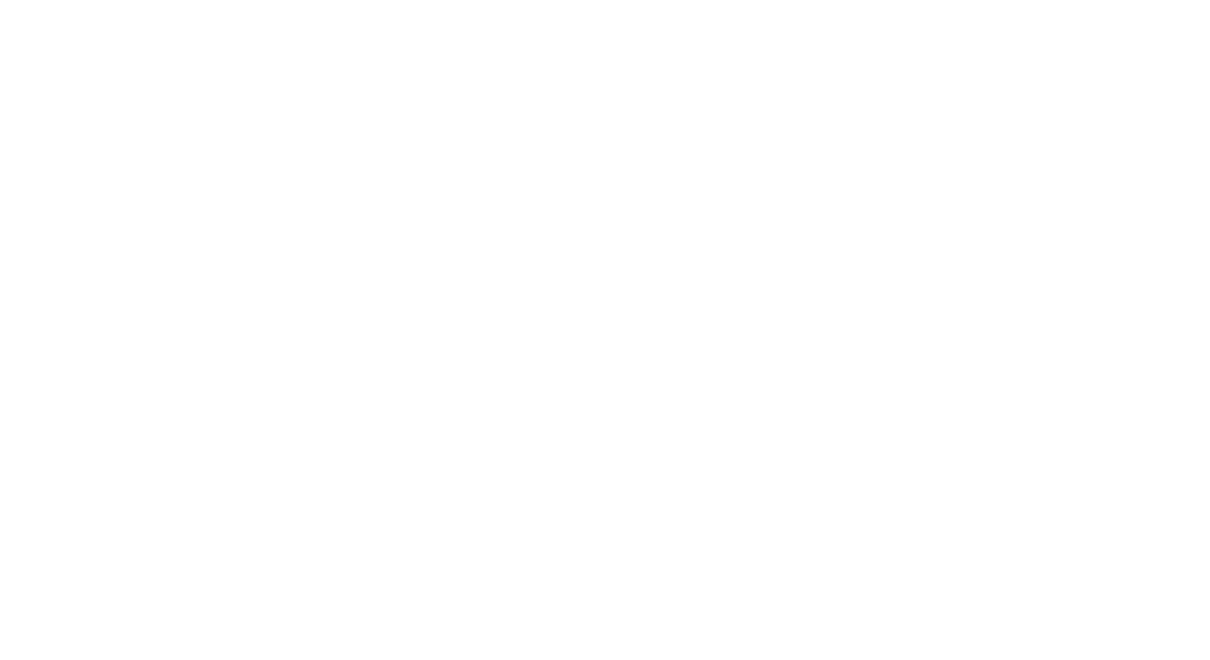

<IPython.core.display.Javascript object>


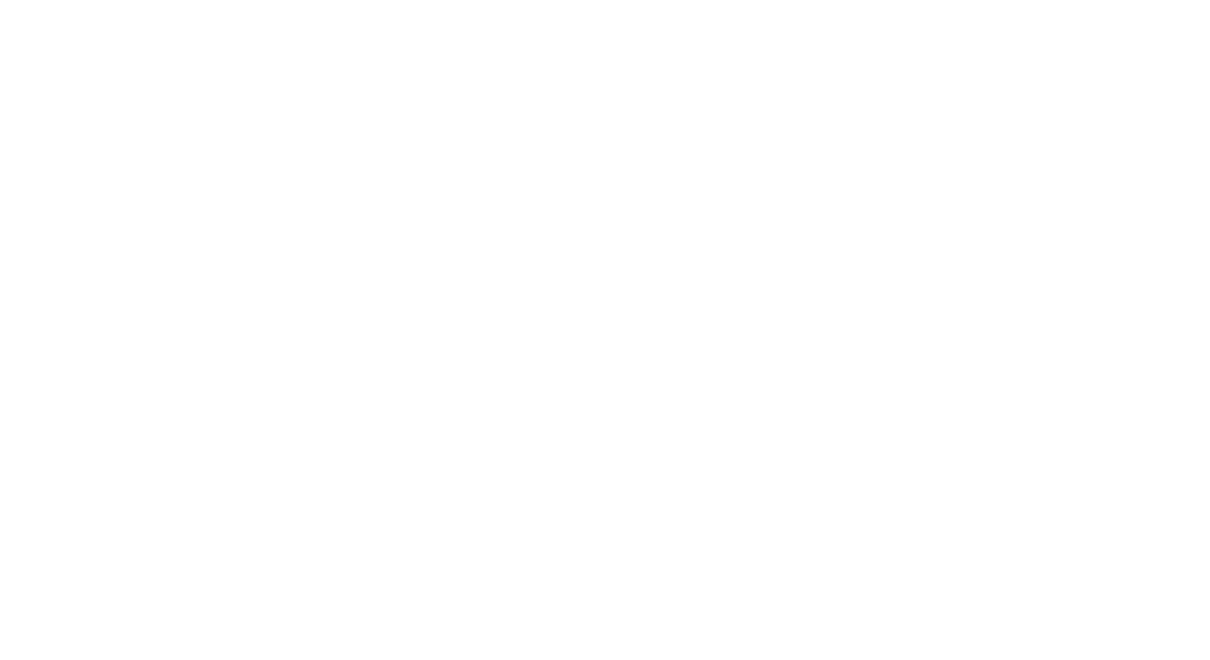

<IPython.core.display.Javascript object>


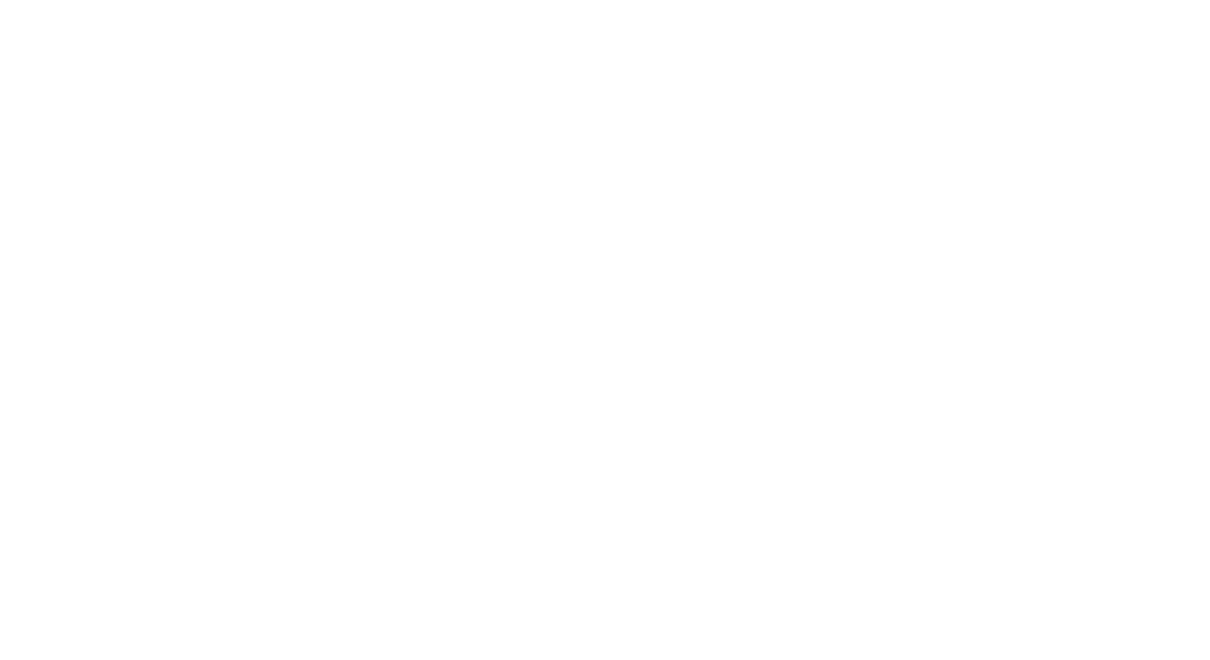

<IPython.core.display.Javascript object>


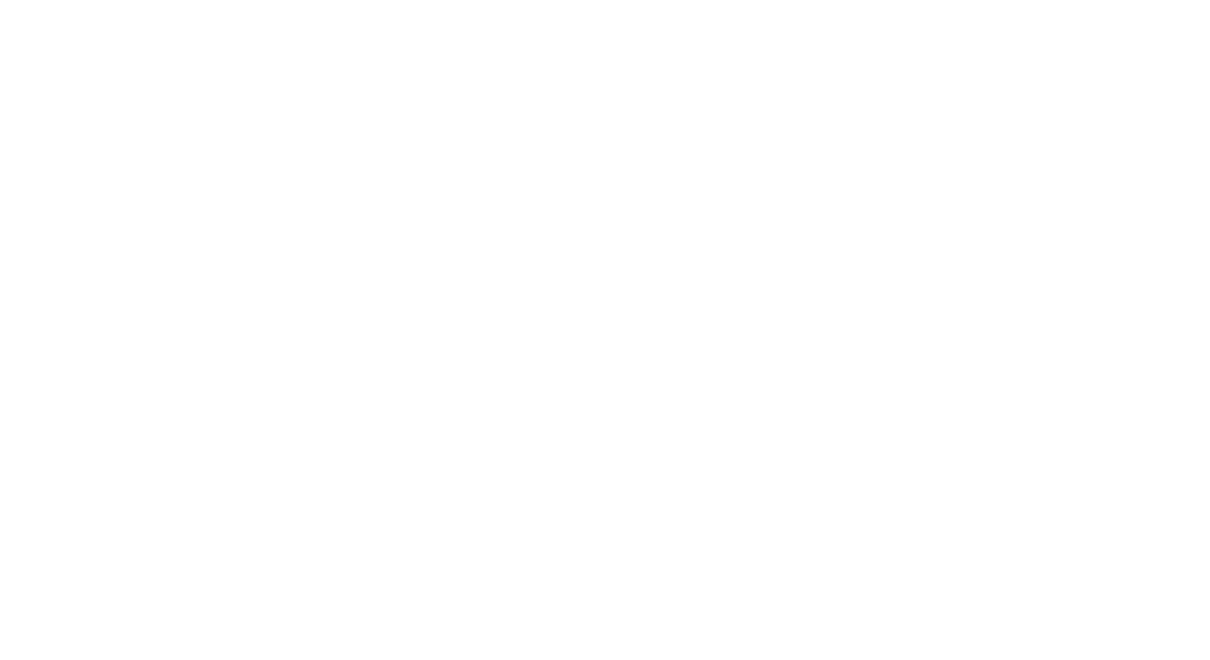

<IPython.core.display.Javascript object>


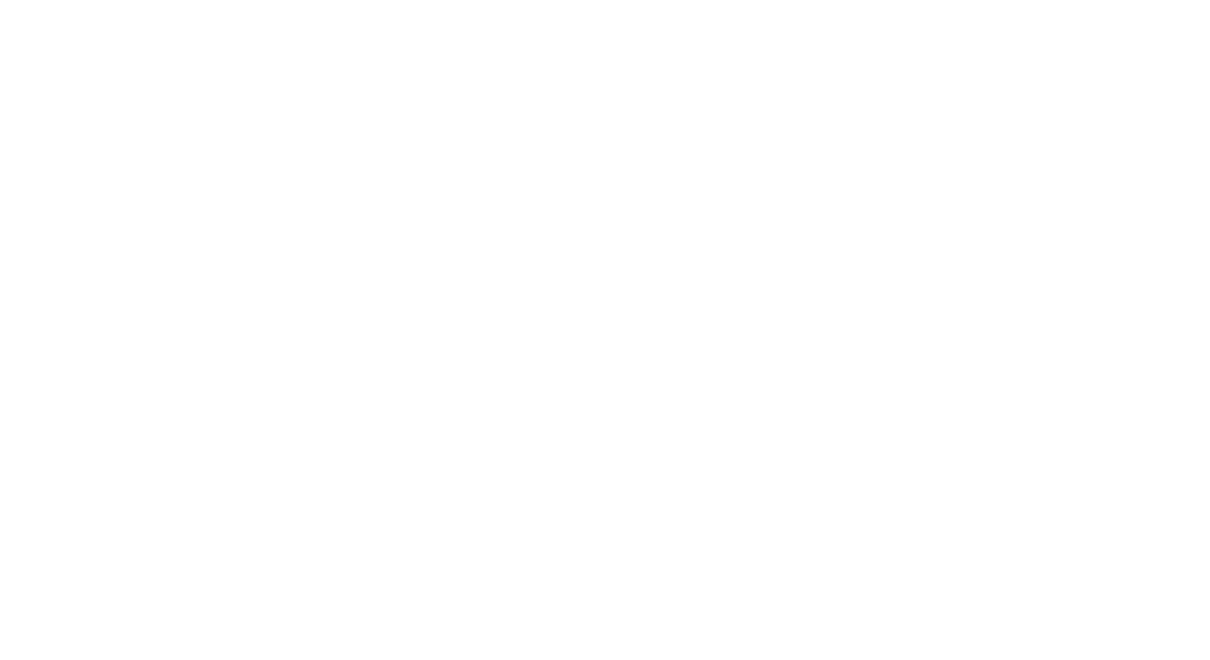

<IPython.core.display.Javascript object>


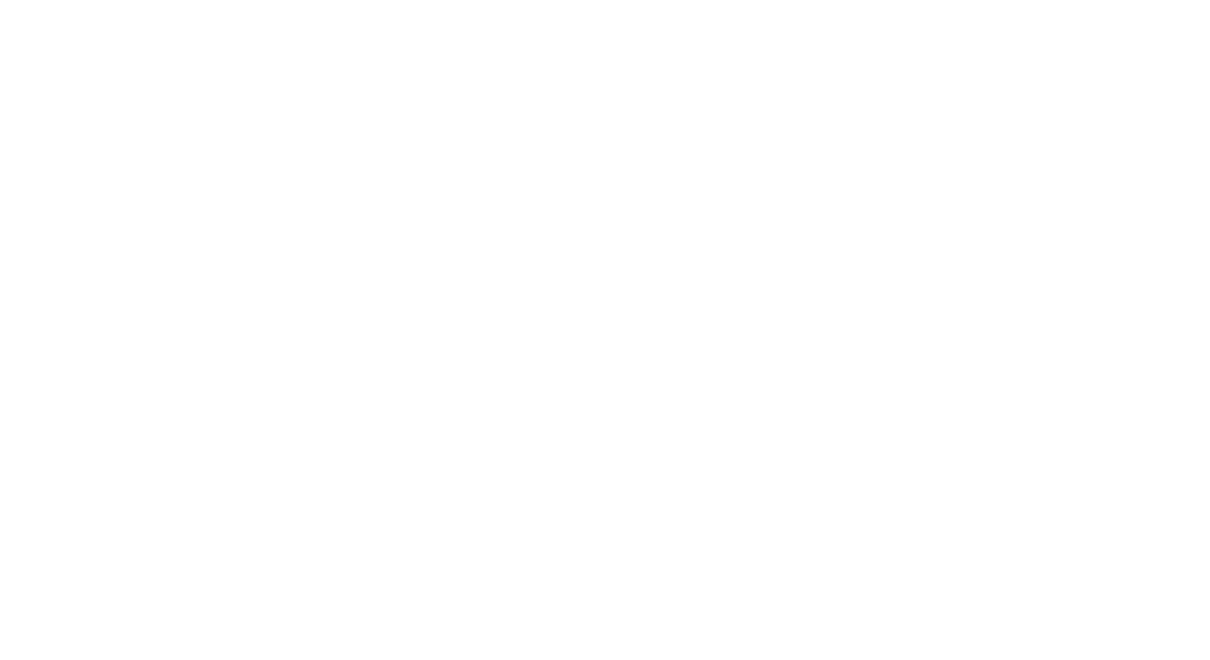

<IPython.core.display.Javascript object>


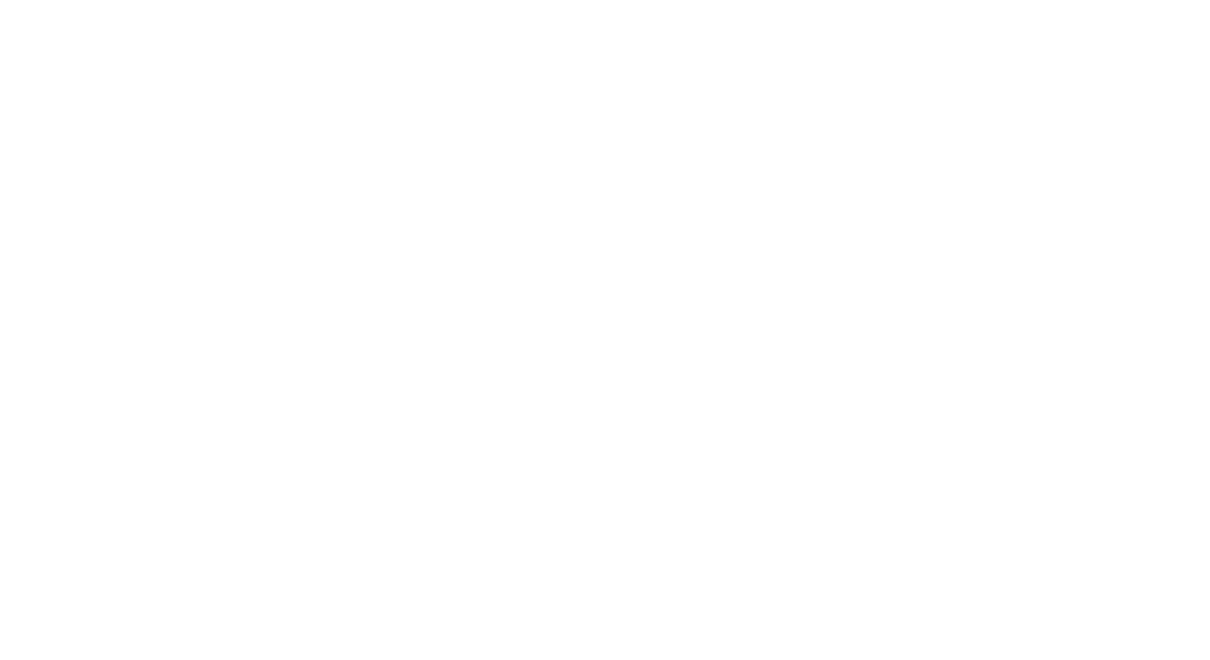

<IPython.core.display.Javascript object>


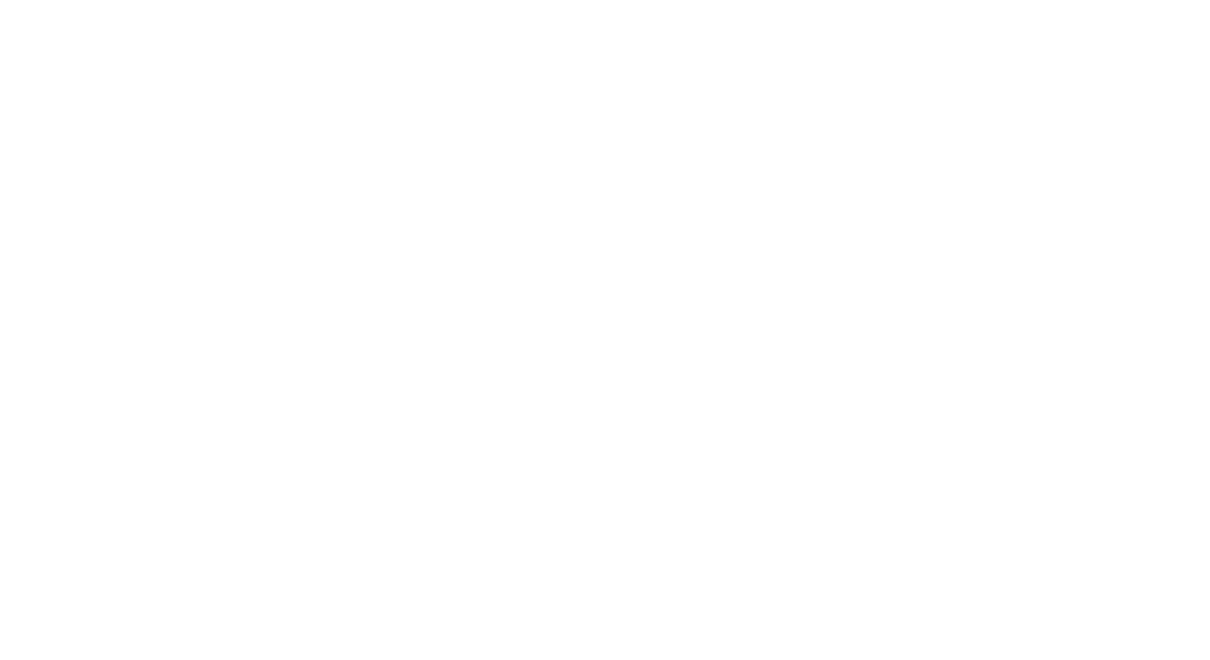

<IPython.core.display.Javascript object>


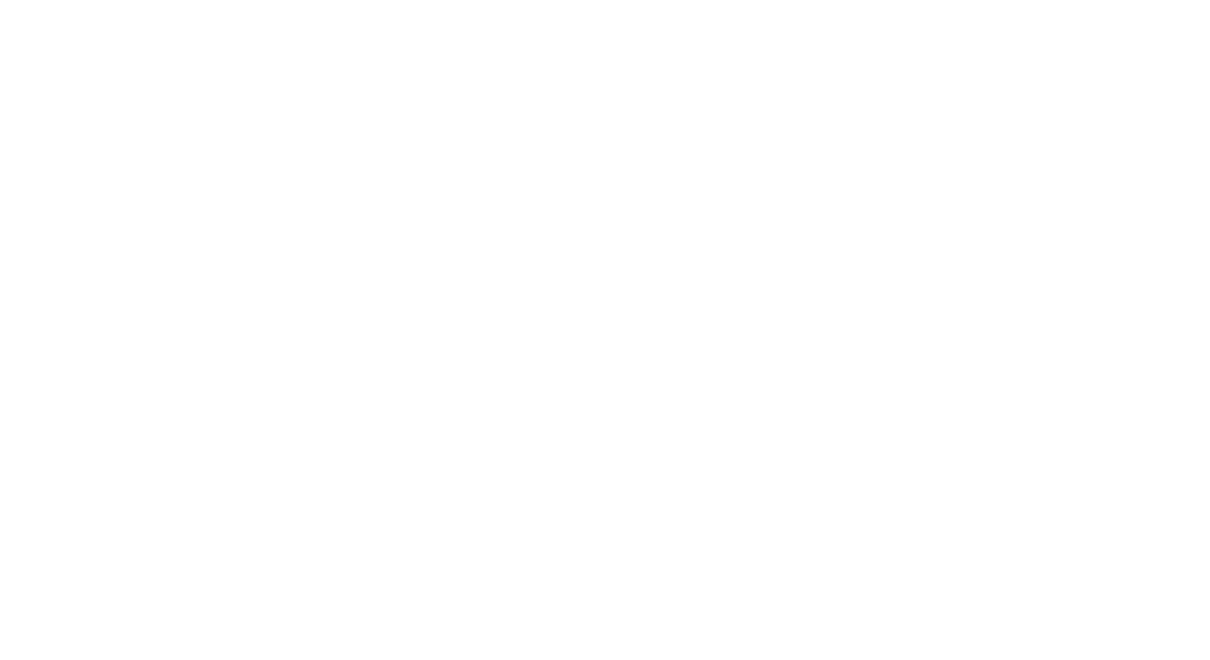

<IPython.core.display.Javascript object>


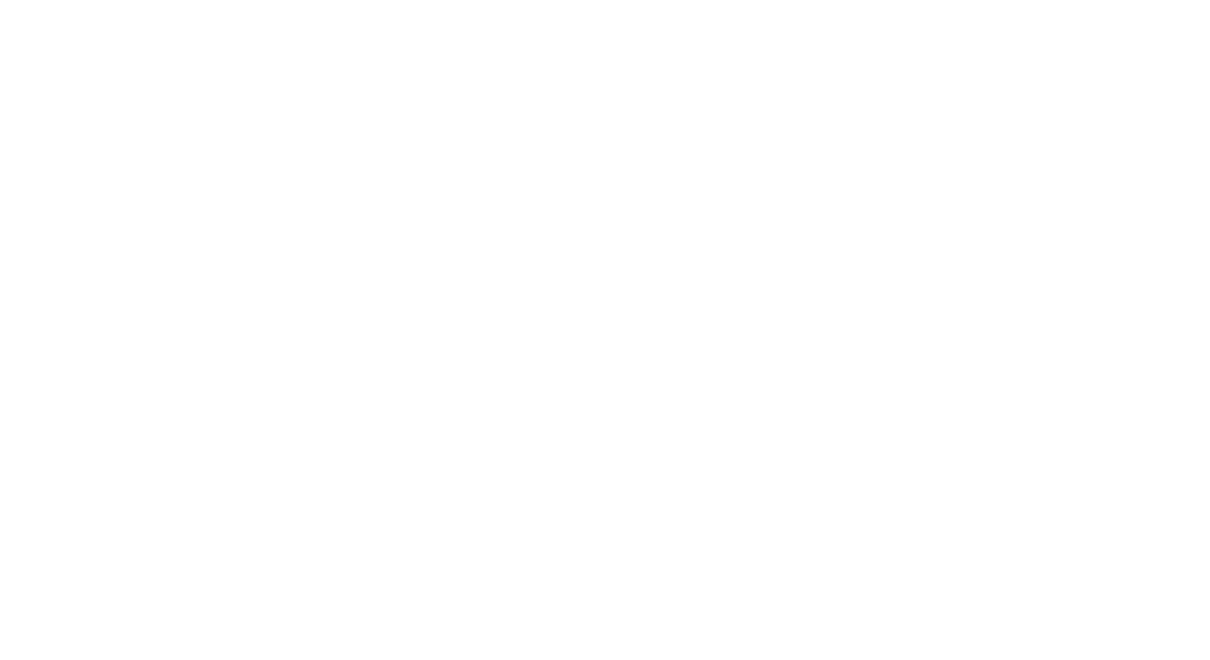

<IPython.core.display.Javascript object>


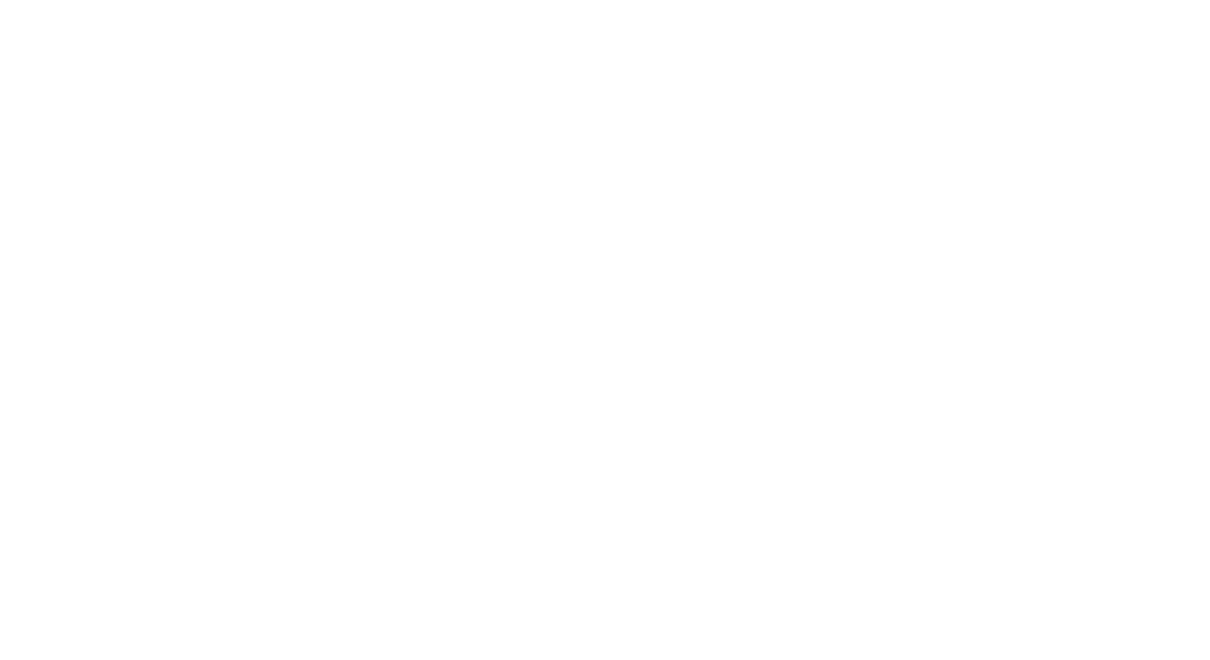

<IPython.core.display.Javascript object>


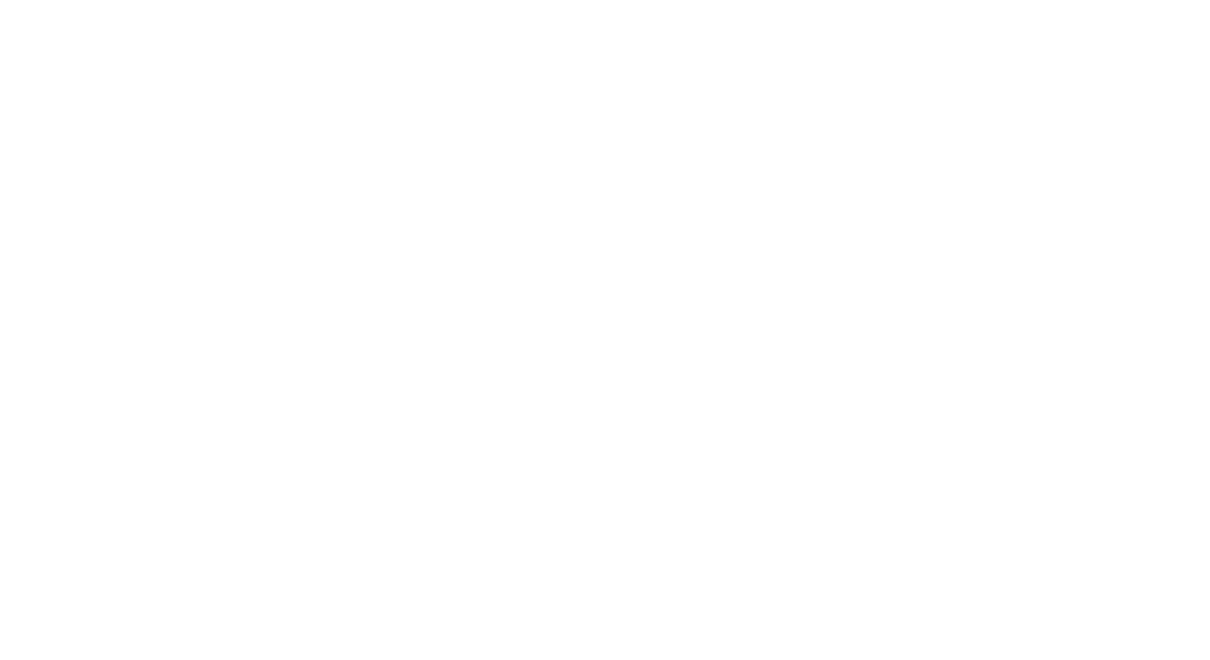

<IPython.core.display.Javascript object>


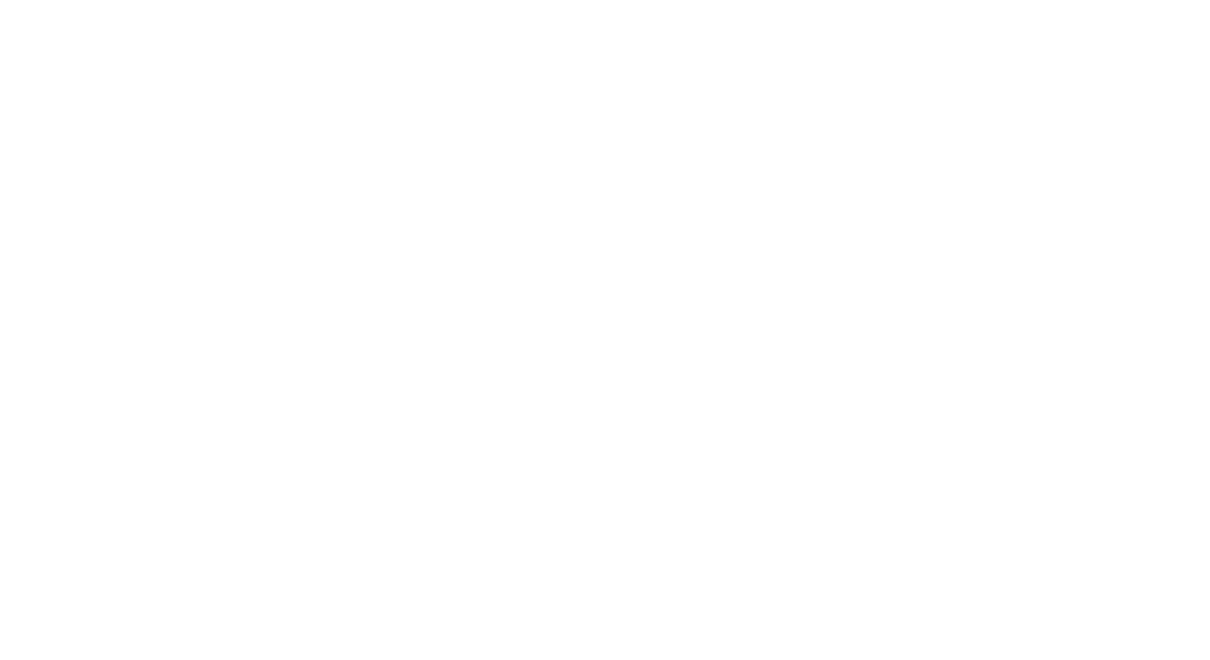

<IPython.core.display.Javascript object>


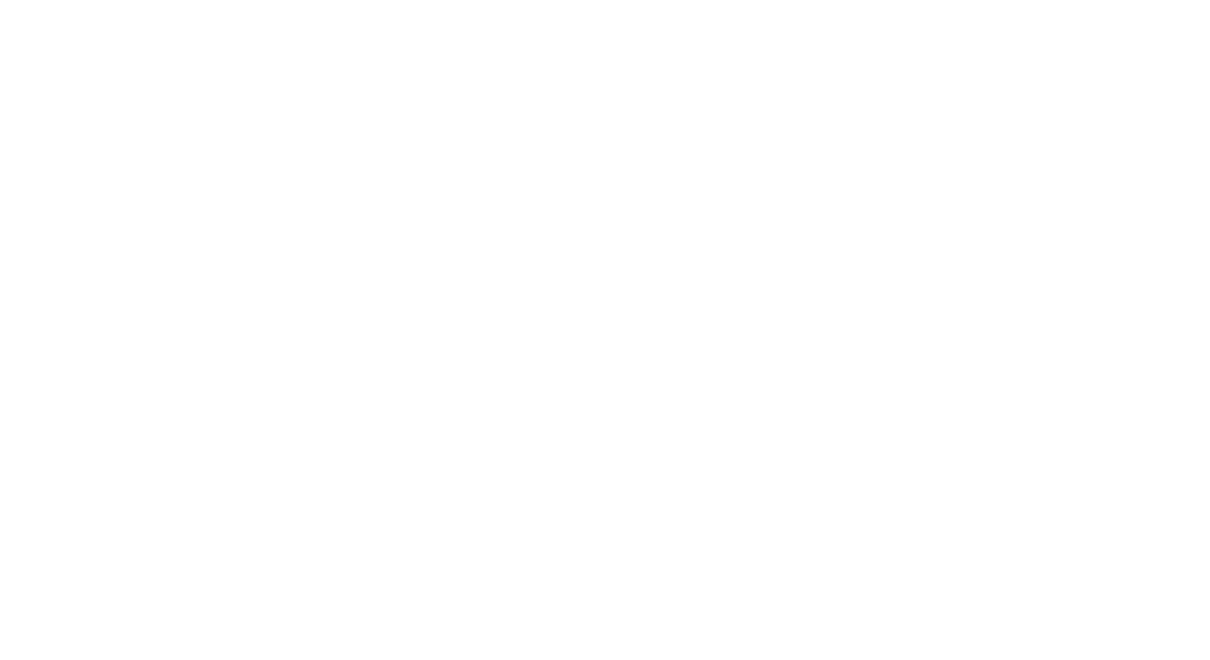

<IPython.core.display.Javascript object>


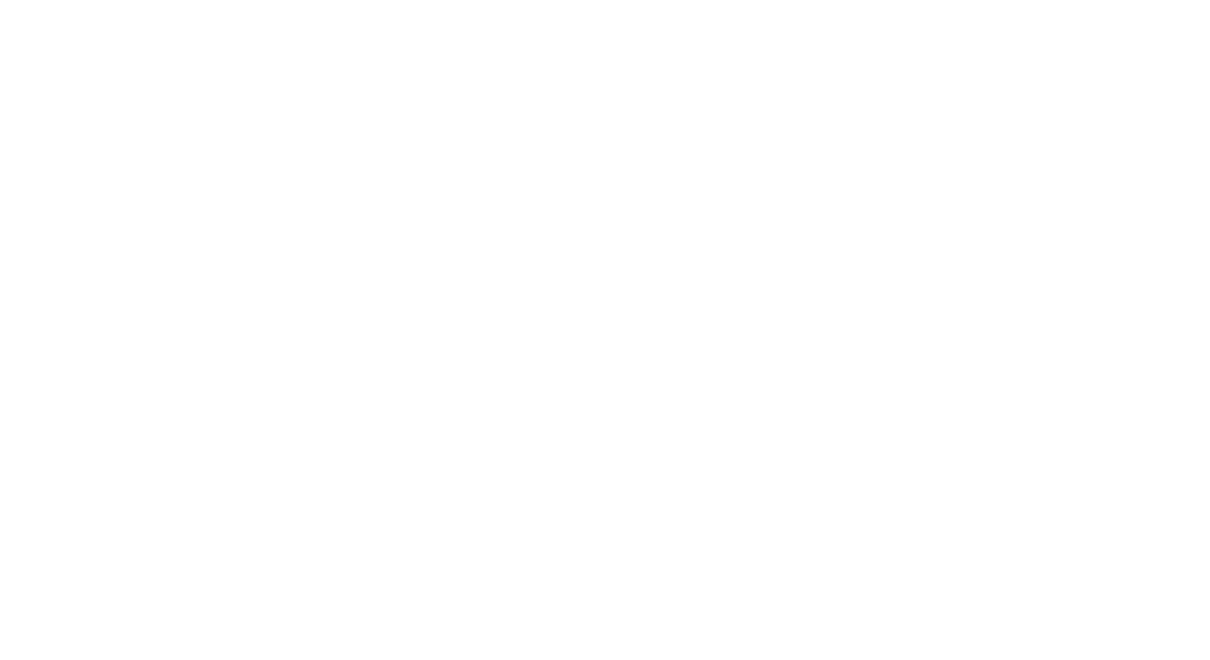

<IPython.core.display.Javascript object>


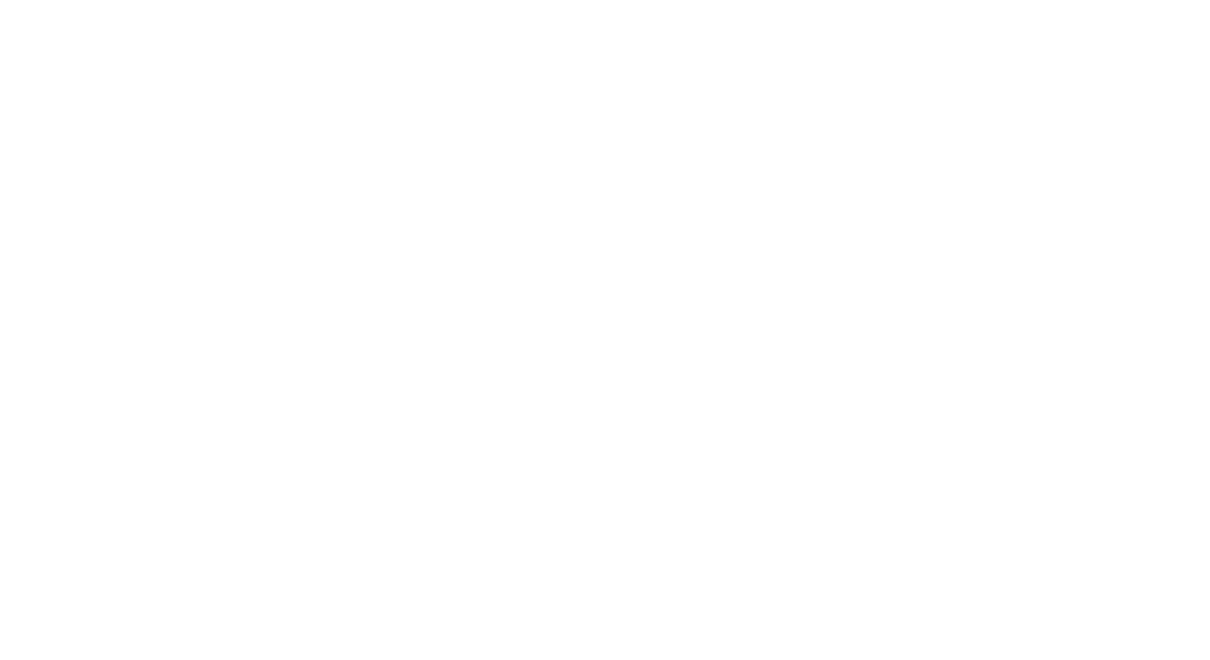

<IPython.core.display.Javascript object>


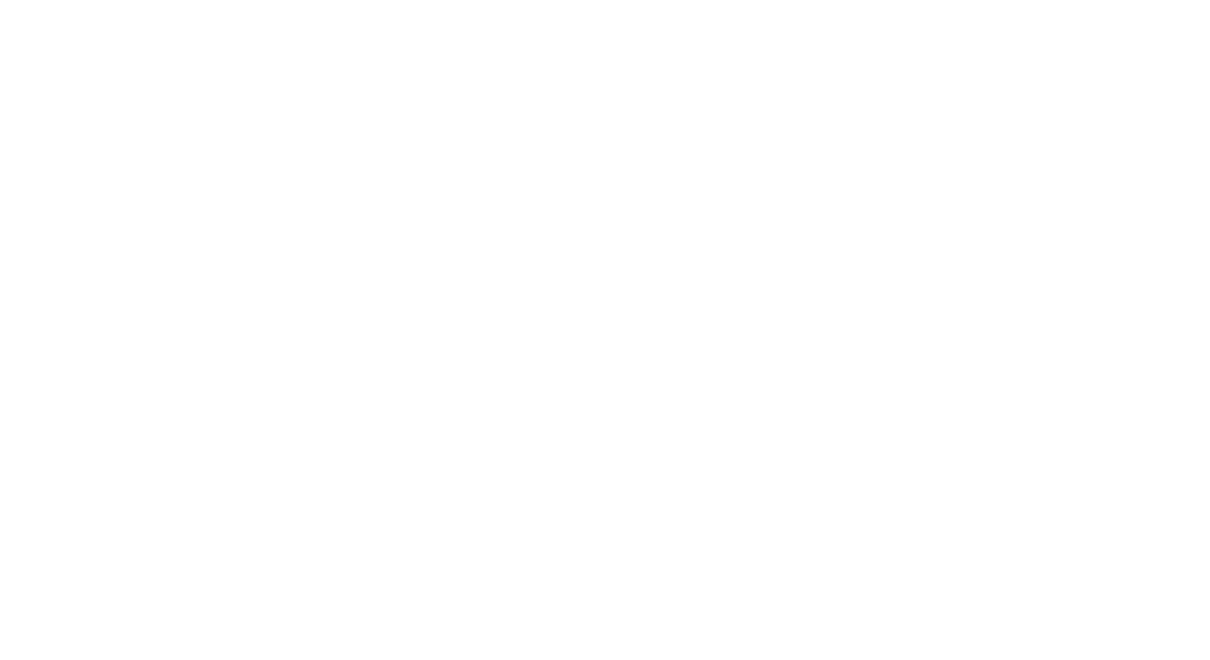

<IPython.core.display.Javascript object>


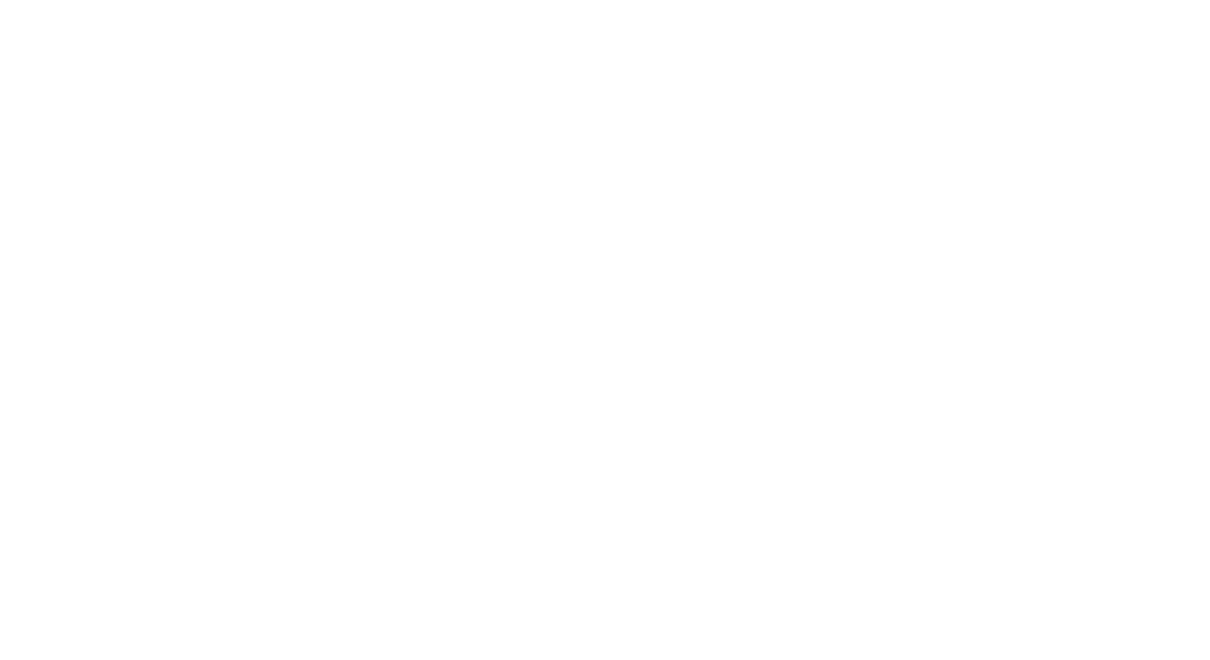

<IPython.core.display.Javascript object>


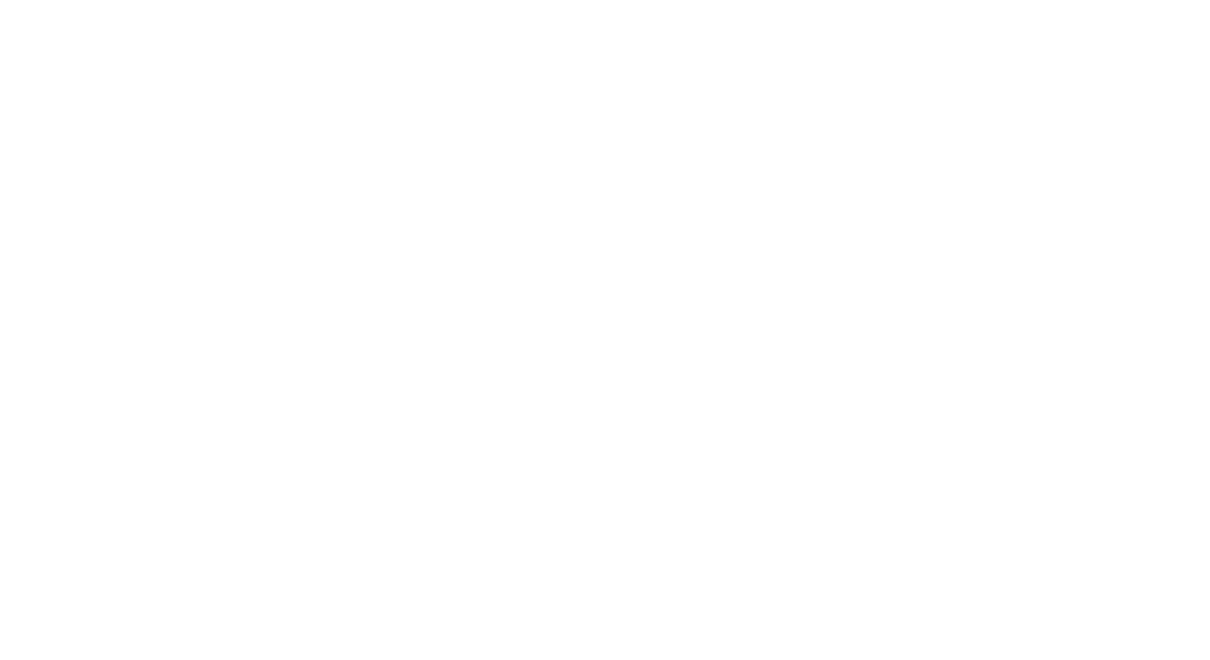

<IPython.core.display.Javascript object>


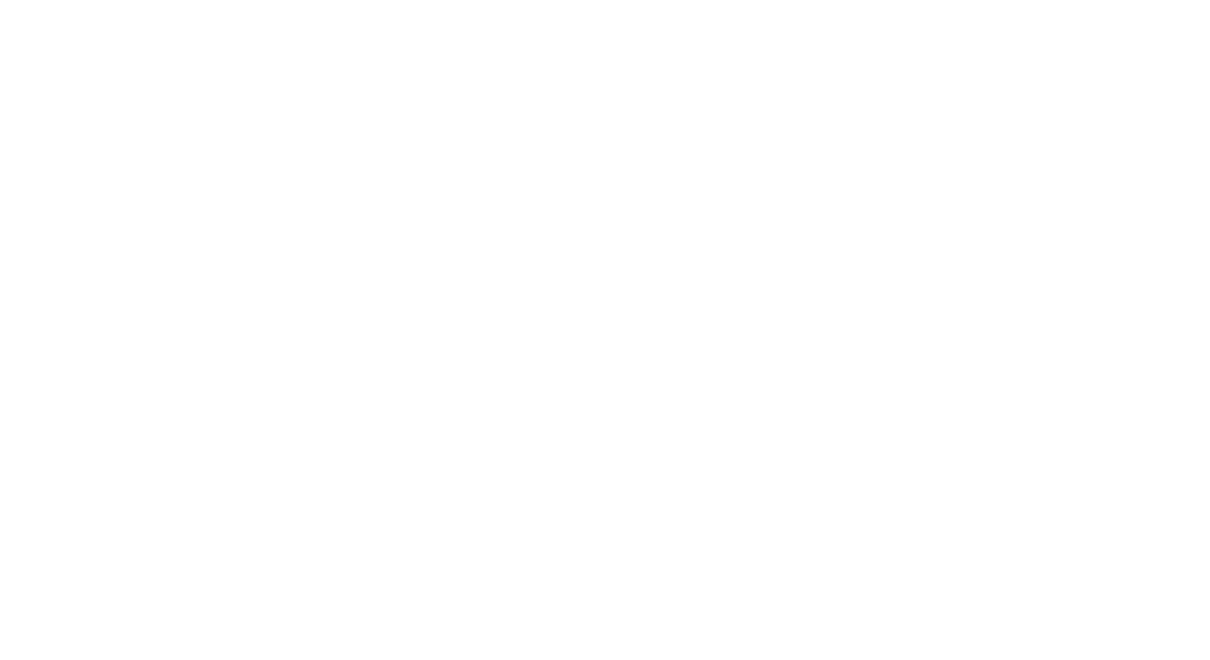

<IPython.core.display.Javascript object>


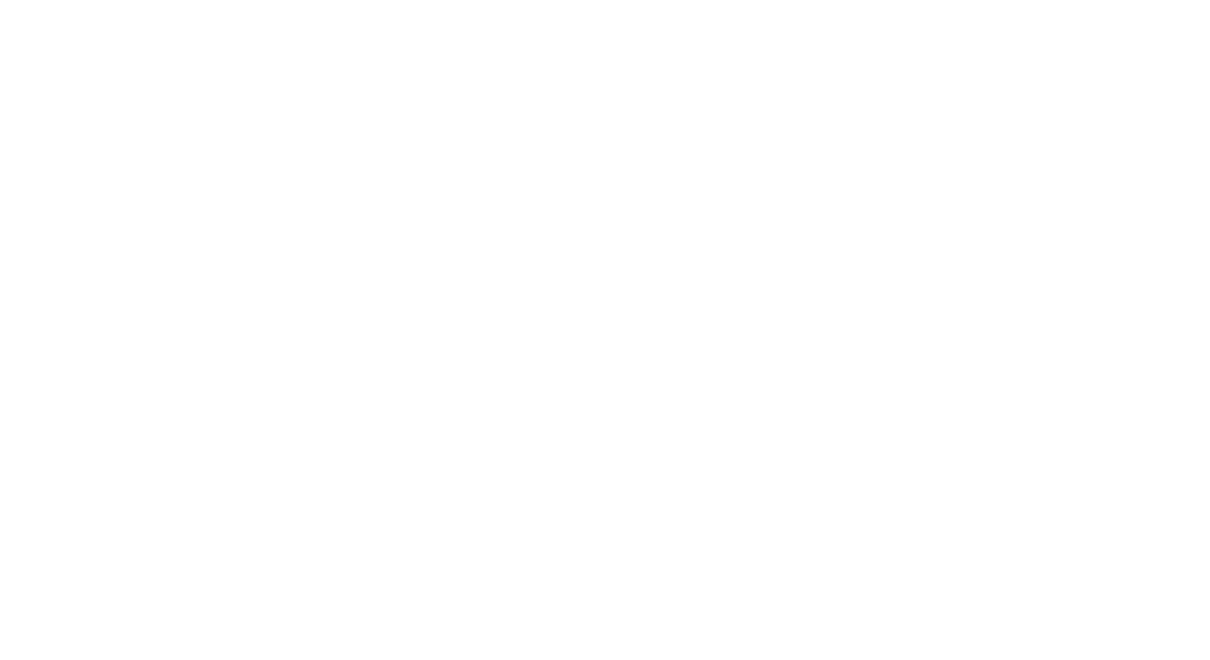

<IPython.core.display.Javascript object>


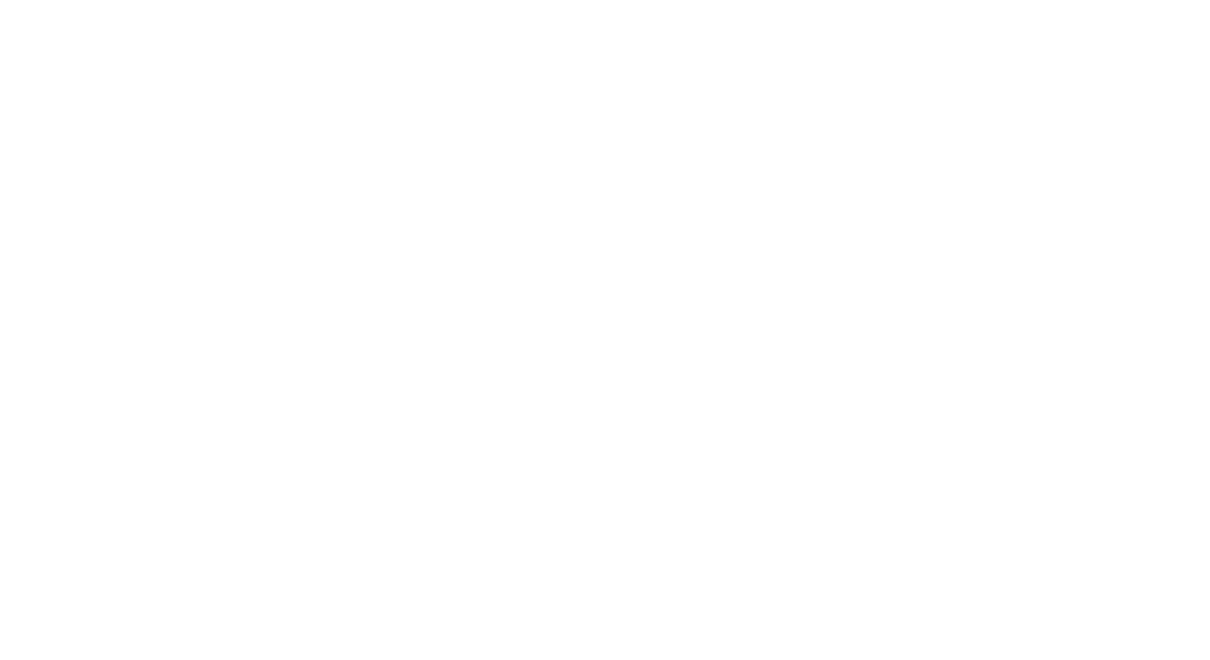

<IPython.core.display.Javascript object>


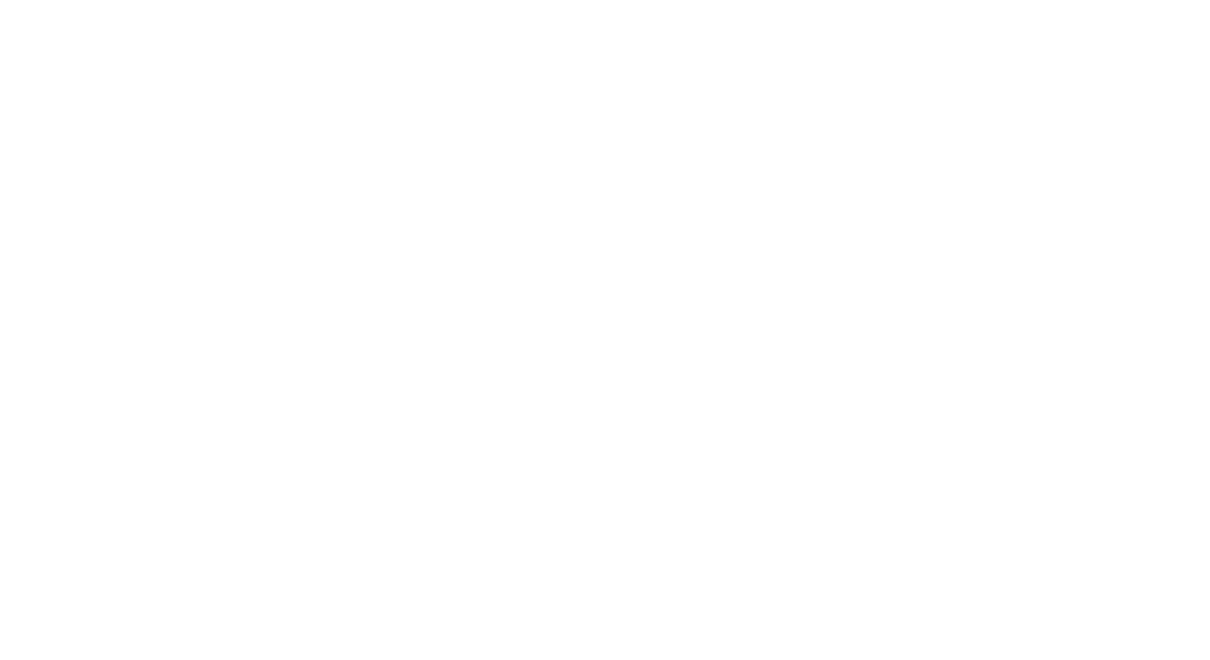

<IPython.core.display.Javascript object>


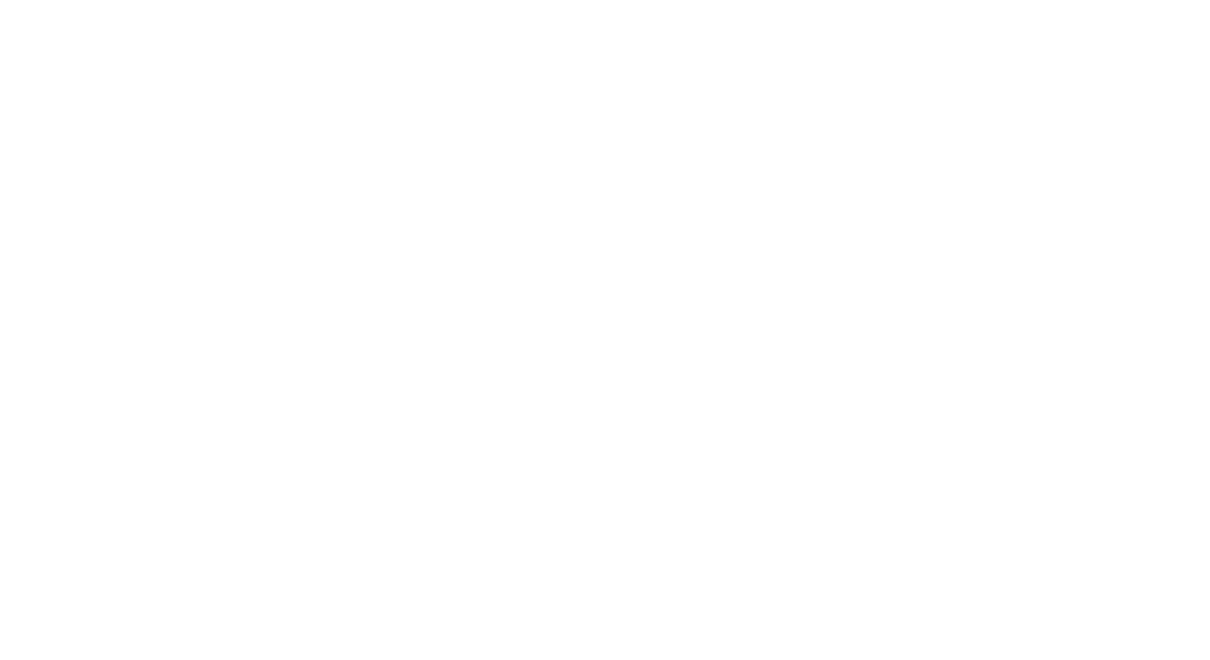

<IPython.core.display.Javascript object>


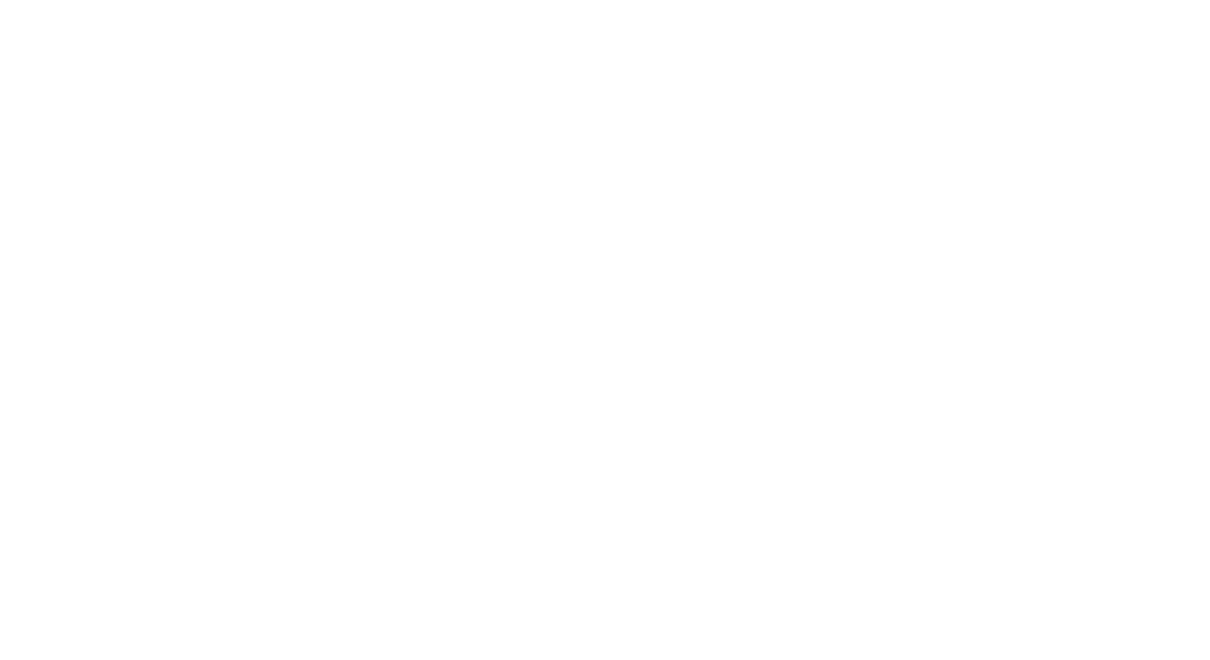

<IPython.core.display.Javascript object>


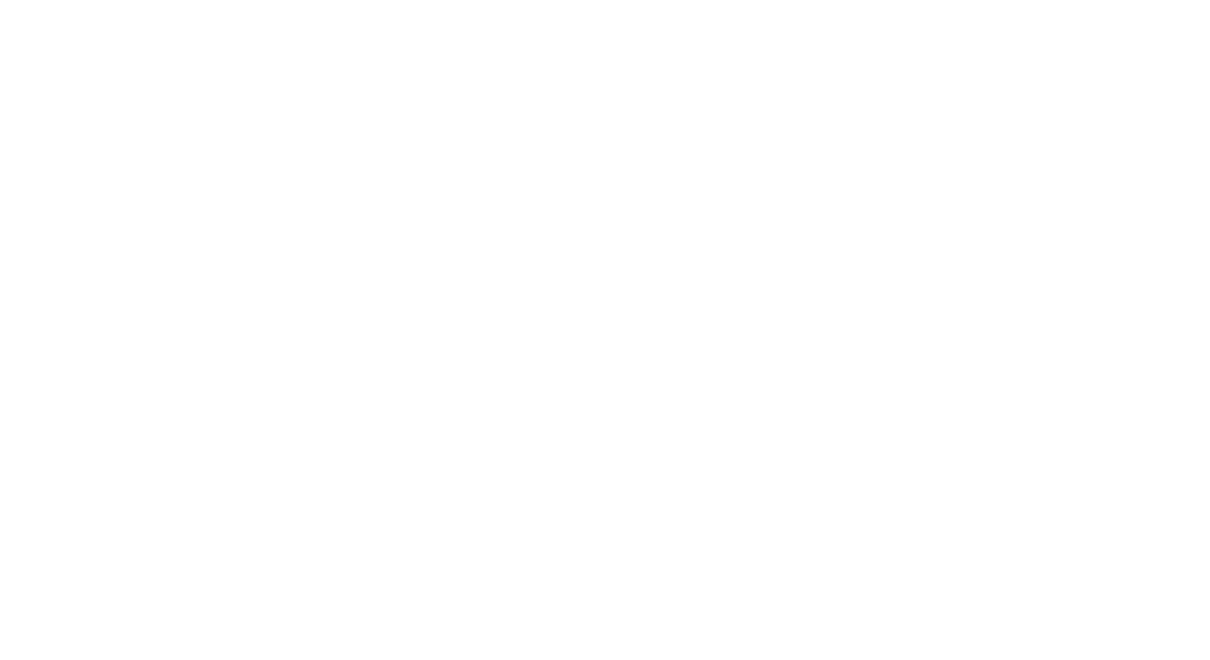

<IPython.core.display.Javascript object>


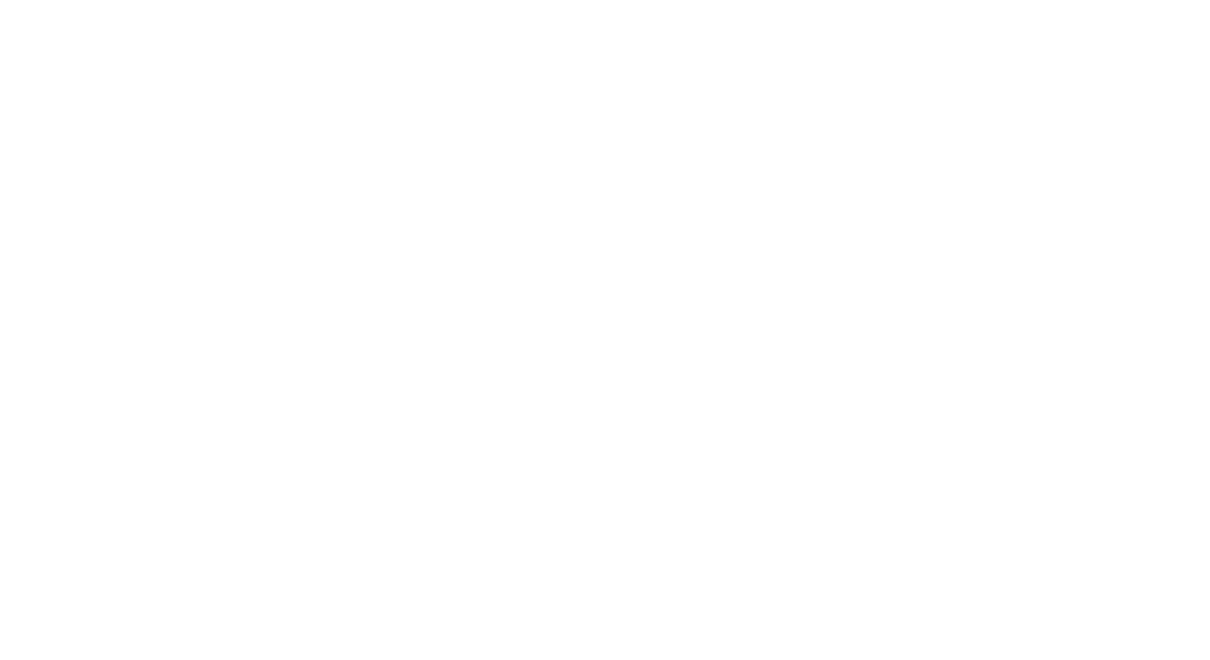

<IPython.core.display.Javascript object>


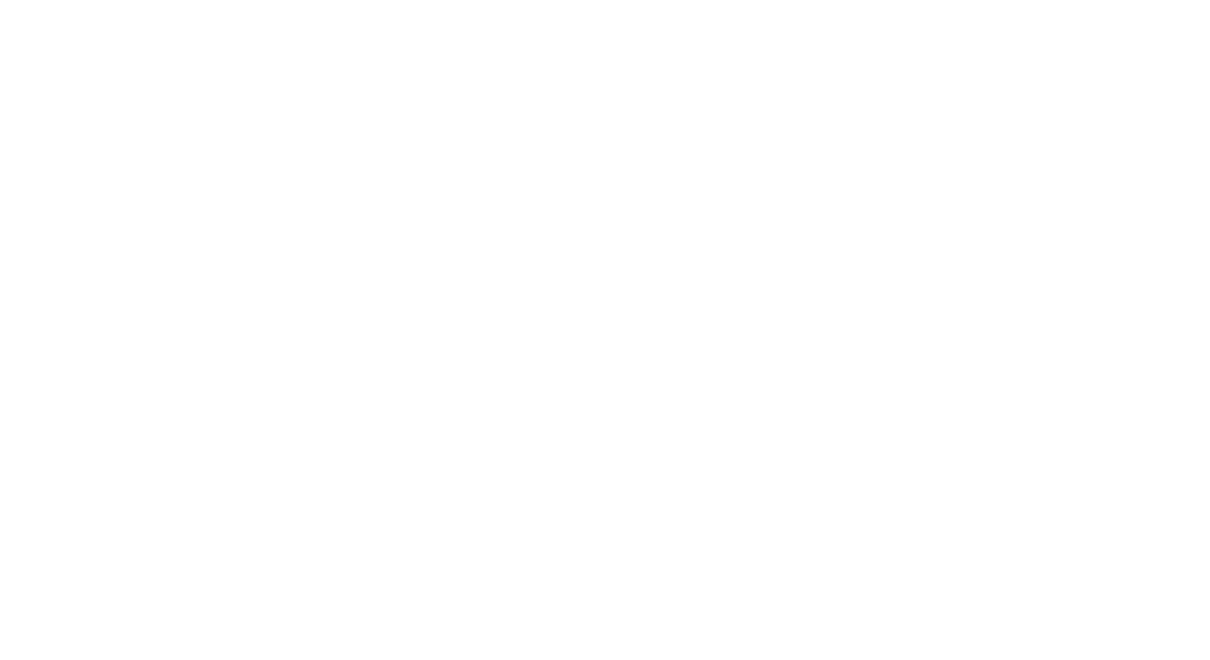

<IPython.core.display.Javascript object>


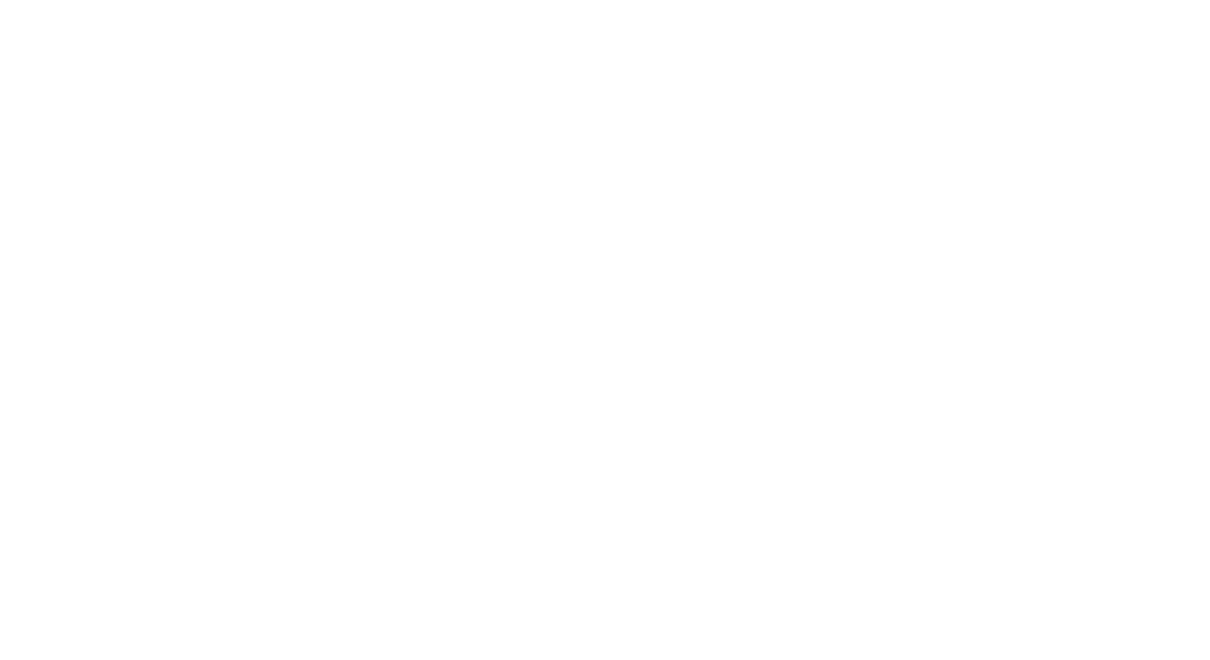

<IPython.core.display.Javascript object>


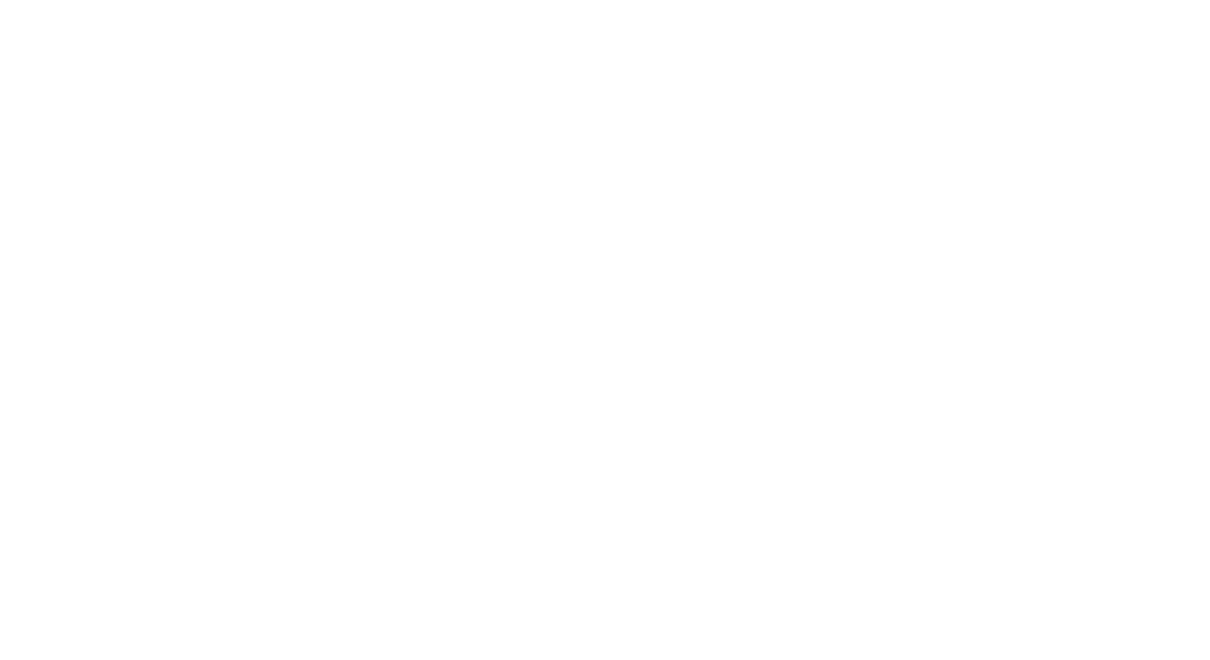

<IPython.core.display.Javascript object>


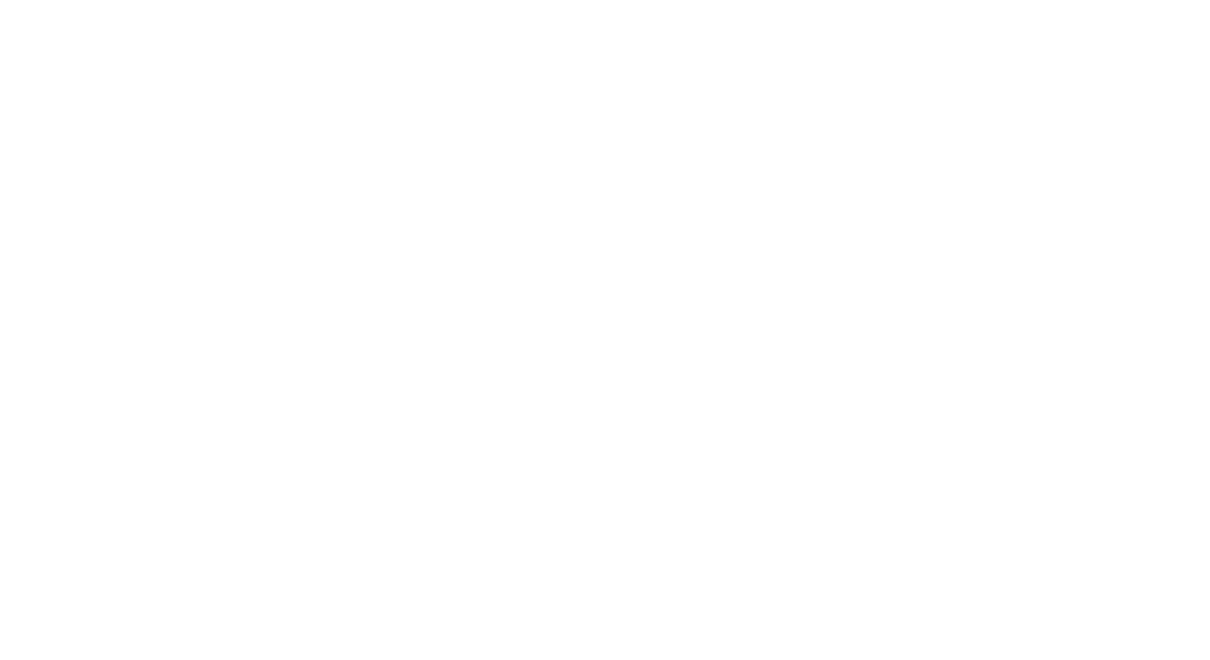

<IPython.core.display.Javascript object>


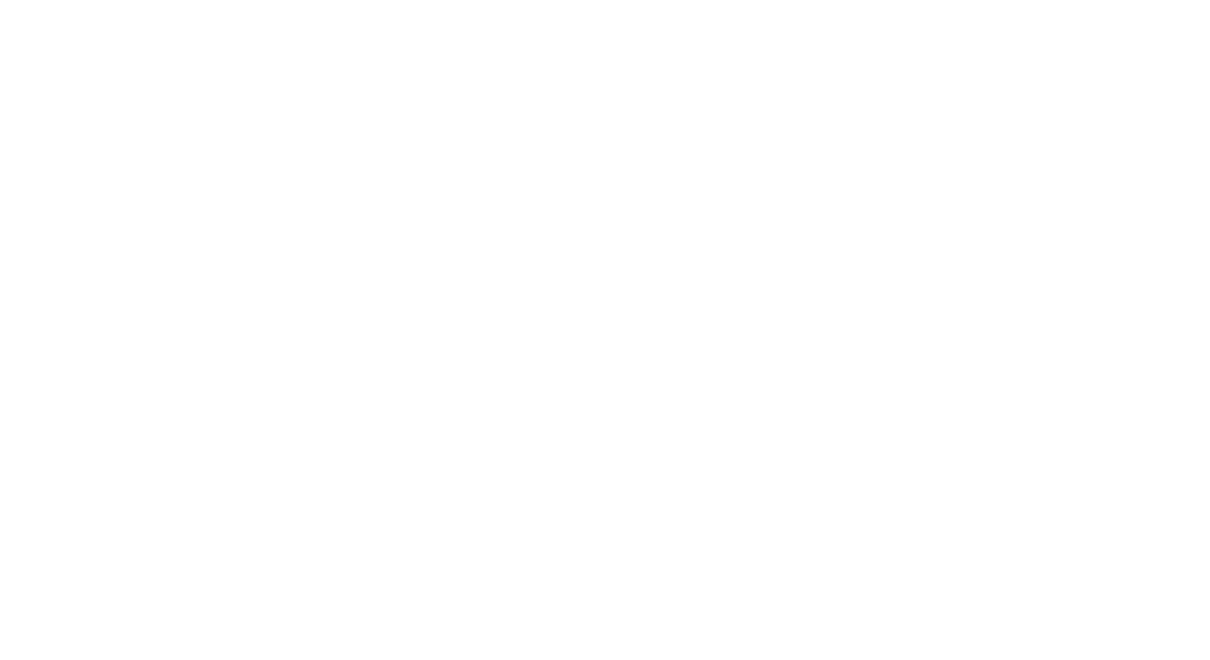

<IPython.core.display.Javascript object>


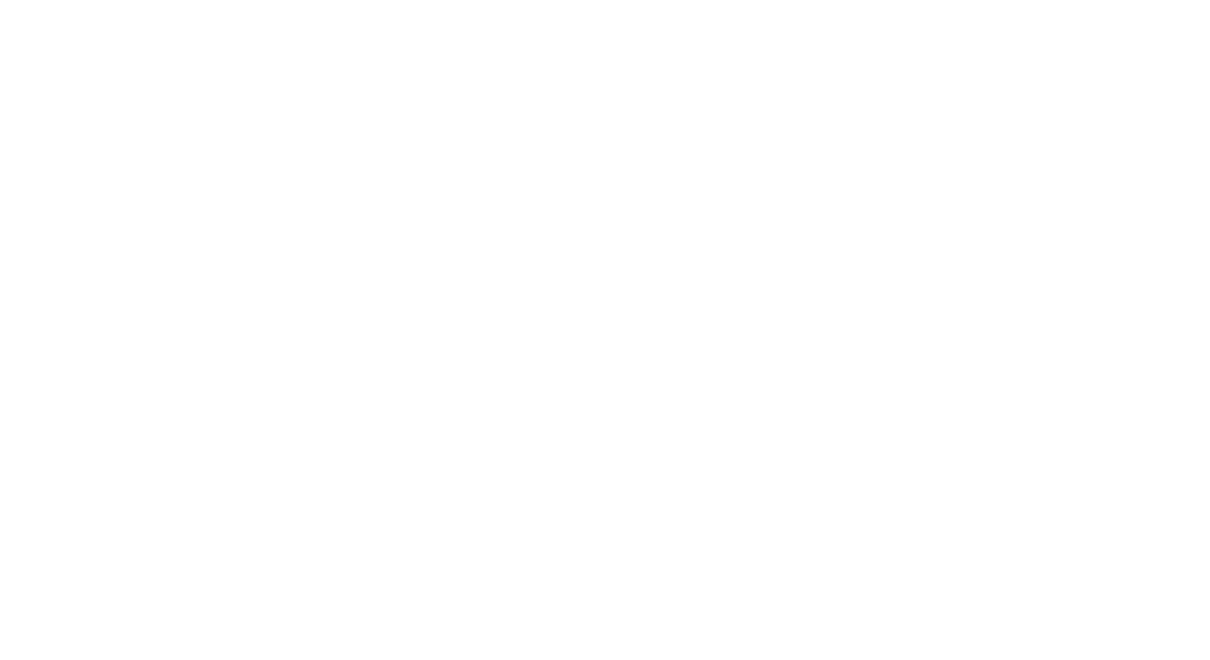

In [167]:
for tVar in OutCols2[1:]:
    Monther = "Jan"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( JanCCVDF[OutCols2[3]].max(), JanCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    JanCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Feb"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( FebCCVDF[OutCols2[3]].max(), FebCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    FebCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()    
    Monther = "Mar"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( MarCCVDF[OutCols2[3]].max(), MarCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    MarCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Apr"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( AprCCVDF[OutCols2[3]].max(), AprCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    AprCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "May"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( MayCCVDF[OutCols2[3]].max(), MayCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    MayCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Jun"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( JunCCVDF[OutCols2[3]].max(), JunCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    JunCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Jul"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( JulCCVDF[OutCols2[3]].max(), JulCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    JulCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Aug"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( AugCCVDF[OutCols2[3]].max(), AugCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    AugCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Sep"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( SepCCVDF[OutCols2[3]].max(), SepCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    SepCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Oct"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( OctCCVDF[OutCols2[3]].max(), OctCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    OctCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Nov"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( NovCCVDF[OutCols2[3]].max(), NovCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    NovCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    Monther = "Dec"
    if tVar in OutCols2[3:]:
        MaxYL = round( max( DecCCVDF[OutCols2[3]].max(), DecCCVDF[OutCols2[4]].max() ) + 10.0, 
                       -1 )
    else:
        MaxYL = 1.2
    cFigName = "CCVHex_%s_%s.png" % (tVar, Monther)
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(11.0, 6.0)
    ax11 = Fig1.add_subplot(111)
    DecCCVDF.plot.hexbin( x="h_offset", y=tVar, gridsize=20, cmap=CmapDict[tVar][0], 
                          ax=ax11 )
    ax11.set_ylim( (0.0, MaxYL) )
    ax11.set_xlim( (0.0, 80000) )
    ax11.set_title("%s %s" % (Monther, CmapDict[tVar][1]), fontsize=16)
    ax11.set_xlabel(r'Offset $\|$h$\|$', fontsize=12)
    ax11.set_ylabel(CmapDict[tVar][2], fontsize=12)
    ax11.tick_params(axis='both', which='major', labelsize=11)
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
# end of for